In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_1_1_connectivity_data_norm_e_k5_b25_t1_1_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(6820875, 92)
(6820875, 15)
validation
(805573, 92)
(805573, 15)
test
(997564, 92)
(997564, 15)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 15)                1935      


Total params: 786191 (3.00 MB)


Trainable params: 786191 (3.00 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/683 [..............................] - ETA: 13:58 - loss: 2.9283 - STD: 0.0403 - MAE: 0.1246

  7/683 [..............................] - ETA: 5s - loss: 2.7524 - STD: 0.0243 - MAE: 0.1241   

 13/683 [..............................] - ETA: 5s - loss: 2.7342 - STD: 0.0235 - MAE: 0.1240

 19/683 [..............................] - ETA: 5s - loss: 2.7217 - STD: 0.0214 - MAE: 0.1240

 25/683 [>.............................] - ETA: 5s - loss: 2.7147 - STD: 0.0197 - MAE: 0.1240

 32/683 [>.............................] - ETA: 5s - loss: 2.7097 - STD: 0.0183 - MAE: 0.1240

 38/683 [>.............................] - ETA: 5s - loss: 2.7064 - STD: 0.0179 - MAE: 0.1240

 45/683 [>.............................] - ETA: 5s - loss: 2.7038 - STD: 0.0176 - MAE: 0.1240

 52/683 [=>............................] - ETA: 5s - loss: 2.7018 - STD: 0.0171 - MAE: 0.1240

 59/683 [=>............................] - ETA: 5s - loss: 2.7001 - STD: 0.0167 - MAE: 0.1240

 65/683 [=>............................] - ETA: 5s - loss: 2.6988 - STD: 0.0166 - MAE: 0.1240

 71/683 [==>...........................] - ETA: 5s - loss: 2.6975 - STD: 0.0164 - MAE: 0.1240

 78/683 [==>...........................] - ETA: 5s - loss: 2.6955 - STD: 0.0162 - MAE: 0.1240

 84/683 [==>...........................] - ETA: 5s - loss: 2.6927 - STD: 0.0163 - MAE: 0.1240

 90/683 [==>...........................] - ETA: 5s - loss: 2.6885 - STD: 0.0164 - MAE: 0.1239

 96/683 [===>..........................] - ETA: 4s - loss: 2.6832 - STD: 0.0170 - MAE: 0.1239

103/683 [===>..........................] - ETA: 4s - loss: 2.6764 - STD: 0.0180 - MAE: 0.1238

109/683 [===>..........................] - ETA: 4s - loss: 2.6708 - STD: 0.0188 - MAE: 0.1237

115/683 [====>.........................] - ETA: 4s - loss: 2.6652 - STD: 0.0196 - MAE: 0.1236

122/683 [====>.........................] - ETA: 4s - loss: 2.6595 - STD: 0.0204 - MAE: 0.1235

128/683 [====>.........................] - ETA: 4s - loss: 2.6547 - STD: 0.0211 - MAE: 0.1234

134/683 [====>.........................] - ETA: 4s - loss: 2.6500 - STD: 0.0217 - MAE: 0.1234

140/683 [=====>........................] - ETA: 4s - loss: 2.6453 - STD: 0.0223 - MAE: 0.1233

146/683 [=====>........................] - ETA: 4s - loss: 2.6404 - STD: 0.0229 - MAE: 0.1232

152/683 [=====>........................] - ETA: 4s - loss: 2.6355 - STD: 0.0236 - MAE: 0.1231

158/683 [=====>........................] - ETA: 4s - loss: 2.6308 - STD: 0.0243 - MAE: 0.1230

165/683 [======>.......................] - ETA: 4s - loss: 2.6257 - STD: 0.0251 - MAE: 0.1229

172/683 [======>.......................] - ETA: 4s - loss: 2.6206 - STD: 0.0258 - MAE: 0.1228

178/683 [======>.......................] - ETA: 4s - loss: 2.6164 - STD: 0.0264 - MAE: 0.1228

184/683 [=======>......................] - ETA: 4s - loss: 2.6123 - STD: 0.0270 - MAE: 0.1227

190/683 [=======>......................] - ETA: 4s - loss: 2.6085 - STD: 0.0275 - MAE: 0.1226

196/683 [=======>......................] - ETA: 4s - loss: 2.6046 - STD: 0.0280 - MAE: 0.1225

203/683 [=======>......................] - ETA: 4s - loss: 2.6002 - STD: 0.0287 - MAE: 0.1225

209/683 [========>.....................] - ETA: 4s - loss: 2.5967 - STD: 0.0291 - MAE: 0.1224

216/683 [========>.....................] - ETA: 3s - loss: 2.5925 - STD: 0.0297 - MAE: 0.1223

223/683 [========>.....................] - ETA: 3s - loss: 2.5886 - STD: 0.0303 - MAE: 0.1222

230/683 [=========>....................] - ETA: 3s - loss: 2.5848 - STD: 0.0308 - MAE: 0.1222

237/683 [=========>....................] - ETA: 3s - loss: 2.5809 - STD: 0.0313 - MAE: 0.1221

243/683 [=========>....................] - ETA: 3s - loss: 2.5778 - STD: 0.0317 - MAE: 0.1220

249/683 [=========>....................] - ETA: 3s - loss: 2.5748 - STD: 0.0321 - MAE: 0.1220

255/683 [==========>...................] - ETA: 3s - loss: 2.5717 - STD: 0.0325 - MAE: 0.1219

262/683 [==========>...................] - ETA: 3s - loss: 2.5683 - STD: 0.0329 - MAE: 0.1219

269/683 [==========>...................] - ETA: 3s - loss: 2.5649 - STD: 0.0333 - MAE: 0.1218

276/683 [===========>..................] - ETA: 3s - loss: 2.5616 - STD: 0.0338 - MAE: 0.1217

283/683 [===========>..................] - ETA: 3s - loss: 2.5584 - STD: 0.0342 - MAE: 0.1217

290/683 [===========>..................] - ETA: 3s - loss: 2.5552 - STD: 0.0345 - MAE: 0.1216

297/683 [============>.................] - ETA: 3s - loss: 2.5521 - STD: 0.0349 - MAE: 0.1216

304/683 [============>.................] - ETA: 3s - loss: 2.5491 - STD: 0.0353 - MAE: 0.1215

311/683 [============>.................] - ETA: 3s - loss: 2.5462 - STD: 0.0356 - MAE: 0.1214

318/683 [============>.................] - ETA: 3s - loss: 2.5433 - STD: 0.0360 - MAE: 0.1214

325/683 [=============>................] - ETA: 2s - loss: 2.5406 - STD: 0.0364 - MAE: 0.1213

332/683 [=============>................] - ETA: 2s - loss: 2.5379 - STD: 0.0367 - MAE: 0.1213

339/683 [=============>................] - ETA: 2s - loss: 2.5352 - STD: 0.0370 - MAE: 0.1212

346/683 [==============>...............] - ETA: 2s - loss: 2.5327 - STD: 0.0373 - MAE: 0.1212

353/683 [==============>...............] - ETA: 2s - loss: 2.5302 - STD: 0.0376 - MAE: 0.1211

360/683 [==============>...............] - ETA: 2s - loss: 2.5277 - STD: 0.0379 - MAE: 0.1211

367/683 [===============>..............] - ETA: 2s - loss: 2.5252 - STD: 0.0382 - MAE: 0.1210

374/683 [===============>..............] - ETA: 2s - loss: 2.5230 - STD: 0.0385 - MAE: 0.1210

381/683 [===============>..............] - ETA: 2s - loss: 2.5207 - STD: 0.0388 - MAE: 0.1210

388/683 [================>.............] - ETA: 2s - loss: 2.5185 - STD: 0.0390 - MAE: 0.1209

395/683 [================>.............] - ETA: 2s - loss: 2.5163 - STD: 0.0393 - MAE: 0.1209

402/683 [================>.............] - ETA: 2s - loss: 2.5141 - STD: 0.0396 - MAE: 0.1208

409/683 [================>.............] - ETA: 2s - loss: 2.5120 - STD: 0.0398 - MAE: 0.1208

416/683 [=================>............] - ETA: 2s - loss: 2.5099 - STD: 0.0401 - MAE: 0.1207

423/683 [=================>............] - ETA: 2s - loss: 2.5077 - STD: 0.0403 - MAE: 0.1207

430/683 [=================>............] - ETA: 2s - loss: 2.5057 - STD: 0.0406 - MAE: 0.1207

437/683 [==================>...........] - ETA: 2s - loss: 2.5036 - STD: 0.0408 - MAE: 0.1206

444/683 [==================>...........] - ETA: 2s - loss: 2.5015 - STD: 0.0410 - MAE: 0.1206

451/683 [==================>...........] - ETA: 1s - loss: 2.4995 - STD: 0.0413 - MAE: 0.1205

458/683 [===================>..........] - ETA: 1s - loss: 2.4975 - STD: 0.0415 - MAE: 0.1205

465/683 [===================>..........] - ETA: 1s - loss: 2.4956 - STD: 0.0417 - MAE: 0.1204

472/683 [===================>..........] - ETA: 1s - loss: 2.4936 - STD: 0.0420 - MAE: 0.1204

479/683 [====================>.........] - ETA: 1s - loss: 2.4917 - STD: 0.0422 - MAE: 0.1204

486/683 [====================>.........] - ETA: 1s - loss: 2.4897 - STD: 0.0424 - MAE: 0.1203

493/683 [====================>.........] - ETA: 1s - loss: 2.4878 - STD: 0.0426 - MAE: 0.1203

500/683 [====================>.........] - ETA: 1s - loss: 2.4860 - STD: 0.0429 - MAE: 0.1202

507/683 [=====================>........] - ETA: 1s - loss: 2.4841 - STD: 0.0431 - MAE: 0.1202

514/683 [=====================>........] - ETA: 1s - loss: 2.4822 - STD: 0.0433 - MAE: 0.1202

521/683 [=====================>........] - ETA: 1s - loss: 2.4805 - STD: 0.0435 - MAE: 0.1201

528/683 [======================>.......] - ETA: 1s - loss: 2.4786 - STD: 0.0437 - MAE: 0.1201

535/683 [======================>.......] - ETA: 1s - loss: 2.4769 - STD: 0.0439 - MAE: 0.1200

542/683 [======================>.......] - ETA: 1s - loss: 2.4752 - STD: 0.0441 - MAE: 0.1200

548/683 [=======================>......] - ETA: 1s - loss: 2.4737 - STD: 0.0443 - MAE: 0.1200

555/683 [=======================>......] - ETA: 1s - loss: 2.4721 - STD: 0.0445 - MAE: 0.1199

562/683 [=======================>......] - ETA: 1s - loss: 2.4705 - STD: 0.0447 - MAE: 0.1199

569/683 [=======================>......] - ETA: 0s - loss: 2.4688 - STD: 0.0449 - MAE: 0.1199

576/683 [========================>.....] - ETA: 0s - loss: 2.4672 - STD: 0.0451 - MAE: 0.1198

583/683 [========================>.....] - ETA: 0s - loss: 2.4656 - STD: 0.0452 - MAE: 0.1198

590/683 [========================>.....] - ETA: 0s - loss: 2.4641 - STD: 0.0454 - MAE: 0.1198

597/683 [=========================>....] - ETA: 0s - loss: 2.4627 - STD: 0.0456 - MAE: 0.1197

604/683 [=========================>....] - ETA: 0s - loss: 2.4612 - STD: 0.0458 - MAE: 0.1197

611/683 [=========================>....] - ETA: 0s - loss: 2.4597 - STD: 0.0460 - MAE: 0.1197

617/683 [==========================>...] - ETA: 0s - loss: 2.4584 - STD: 0.0461 - MAE: 0.1196

623/683 [==========================>...] - ETA: 0s - loss: 2.4571 - STD: 0.0462 - MAE: 0.1196

629/683 [==========================>...] - ETA: 0s - loss: 2.4558 - STD: 0.0464 - MAE: 0.1196

635/683 [==========================>...] - ETA: 0s - loss: 2.4545 - STD: 0.0465 - MAE: 0.1196

642/683 [===========================>..] - ETA: 0s - loss: 2.4531 - STD: 0.0467 - MAE: 0.1195

649/683 [===========================>..] - ETA: 0s - loss: 2.4516 - STD: 0.0469 - MAE: 0.1195

656/683 [===========================>..] - ETA: 0s - loss: 2.4502 - STD: 0.0470 - MAE: 0.1195

659/683 [===========================>..] - ETA: 0s - loss: 2.4497 - STD: 0.0471 - MAE: 0.1195

665/683 [============================>.] - ETA: 0s - loss: 2.4485 - STD: 0.0472 - MAE: 0.1194

671/683 [============================>.] - ETA: 0s - loss: 2.4474 - STD: 0.0473 - MAE: 0.1194

677/683 [============================>.] - ETA: 0s - loss: 2.4462 - STD: 0.0475 - MAE: 0.1194

683/683 [==============================] - ETA: 0s - loss: 2.4450 - STD: 0.0476 - MAE: 0.1194

683/683 [==============================] - 8s 10ms/step - loss: 2.4450 - STD: 0.0476 - MAE: 0.1194 - val_loss: 2.3280 - val_STD: 0.0640 - val_MAE: 0.1157


Epoch 2/10000


  1/683 [..............................] - ETA: 17s - loss: 2.3152 - STD: 0.0644 - MAE: 0.1162

  8/683 [..............................] - ETA: 5s - loss: 2.3128 - STD: 0.0617 - MAE: 0.1165 

 15/683 [..............................] - ETA: 5s - loss: 2.3108 - STD: 0.0621 - MAE: 0.1165

 22/683 [..............................] - ETA: 5s - loss: 2.3123 - STD: 0.0626 - MAE: 0.1164

 29/683 [>.............................] - ETA: 5s - loss: 2.3120 - STD: 0.0625 - MAE: 0.1164

 35/683 [>.............................] - ETA: 5s - loss: 2.3111 - STD: 0.0625 - MAE: 0.1164

 42/683 [>.............................] - ETA: 5s - loss: 2.3094 - STD: 0.0626 - MAE: 0.1164

 49/683 [=>............................] - ETA: 5s - loss: 2.3080 - STD: 0.0628 - MAE: 0.1163

 55/683 [=>............................] - ETA: 5s - loss: 2.3074 - STD: 0.0627 - MAE: 0.1163

 62/683 [=>............................] - ETA: 5s - loss: 2.3063 - STD: 0.0628 - MAE: 0.1163

 68/683 [=>............................] - ETA: 5s - loss: 2.3059 - STD: 0.0629 - MAE: 0.1163

 75/683 [==>...........................] - ETA: 5s - loss: 2.3051 - STD: 0.0630 - MAE: 0.1163

 81/683 [==>...........................] - ETA: 4s - loss: 2.3043 - STD: 0.0630 - MAE: 0.1163

 88/683 [==>...........................] - ETA: 4s - loss: 2.3030 - STD: 0.0632 - MAE: 0.1162

 95/683 [===>..........................] - ETA: 4s - loss: 2.3021 - STD: 0.0632 - MAE: 0.1162

102/683 [===>..........................] - ETA: 4s - loss: 2.3010 - STD: 0.0633 - MAE: 0.1162

109/683 [===>..........................] - ETA: 4s - loss: 2.3005 - STD: 0.0634 - MAE: 0.1162

116/683 [====>.........................] - ETA: 4s - loss: 2.3005 - STD: 0.0635 - MAE: 0.1161

123/683 [====>.........................] - ETA: 4s - loss: 2.3000 - STD: 0.0635 - MAE: 0.1161

129/683 [====>.........................] - ETA: 4s - loss: 2.2993 - STD: 0.0635 - MAE: 0.1161

136/683 [====>.........................] - ETA: 4s - loss: 2.2988 - STD: 0.0636 - MAE: 0.1161

143/683 [=====>........................] - ETA: 4s - loss: 2.2980 - STD: 0.0637 - MAE: 0.1161

150/683 [=====>........................] - ETA: 4s - loss: 2.2973 - STD: 0.0637 - MAE: 0.1161

157/683 [=====>........................] - ETA: 4s - loss: 2.2969 - STD: 0.0638 - MAE: 0.1161

163/683 [======>.......................] - ETA: 4s - loss: 2.2965 - STD: 0.0639 - MAE: 0.1161

170/683 [======>.......................] - ETA: 4s - loss: 2.2960 - STD: 0.0639 - MAE: 0.1160

176/683 [======>.......................] - ETA: 4s - loss: 2.2957 - STD: 0.0639 - MAE: 0.1160

182/683 [======>.......................] - ETA: 4s - loss: 2.2952 - STD: 0.0640 - MAE: 0.1160

189/683 [=======>......................] - ETA: 4s - loss: 2.2948 - STD: 0.0640 - MAE: 0.1160

195/683 [=======>......................] - ETA: 4s - loss: 2.2943 - STD: 0.0641 - MAE: 0.1160

201/683 [=======>......................] - ETA: 3s - loss: 2.2936 - STD: 0.0641 - MAE: 0.1160

207/683 [========>.....................] - ETA: 3s - loss: 2.2930 - STD: 0.0642 - MAE: 0.1160

214/683 [========>.....................] - ETA: 3s - loss: 2.2923 - STD: 0.0642 - MAE: 0.1160

220/683 [========>.....................] - ETA: 3s - loss: 2.2919 - STD: 0.0643 - MAE: 0.1159

226/683 [========>.....................] - ETA: 3s - loss: 2.2913 - STD: 0.0643 - MAE: 0.1159

233/683 [=========>....................] - ETA: 3s - loss: 2.2908 - STD: 0.0644 - MAE: 0.1159

240/683 [=========>....................] - ETA: 3s - loss: 2.2903 - STD: 0.0644 - MAE: 0.1159

247/683 [=========>....................] - ETA: 3s - loss: 2.2897 - STD: 0.0645 - MAE: 0.1159

254/683 [==========>...................] - ETA: 3s - loss: 2.2891 - STD: 0.0645 - MAE: 0.1159

260/683 [==========>...................] - ETA: 3s - loss: 2.2887 - STD: 0.0646 - MAE: 0.1159

267/683 [==========>...................] - ETA: 3s - loss: 2.2884 - STD: 0.0647 - MAE: 0.1159

273/683 [==========>...................] - ETA: 3s - loss: 2.2880 - STD: 0.0647 - MAE: 0.1158

280/683 [===========>..................] - ETA: 3s - loss: 2.2882 - STD: 0.0647 - MAE: 0.1158

287/683 [===========>..................] - ETA: 3s - loss: 2.2881 - STD: 0.0648 - MAE: 0.1158

294/683 [===========>..................] - ETA: 3s - loss: 2.2878 - STD: 0.0648 - MAE: 0.1158

301/683 [============>.................] - ETA: 3s - loss: 2.2872 - STD: 0.0648 - MAE: 0.1158

308/683 [============>.................] - ETA: 3s - loss: 2.2869 - STD: 0.0649 - MAE: 0.1158

314/683 [============>.................] - ETA: 3s - loss: 2.2865 - STD: 0.0649 - MAE: 0.1158

320/683 [=============>................] - ETA: 2s - loss: 2.2860 - STD: 0.0650 - MAE: 0.1158

326/683 [=============>................] - ETA: 2s - loss: 2.2856 - STD: 0.0650 - MAE: 0.1158

332/683 [=============>................] - ETA: 2s - loss: 2.2850 - STD: 0.0651 - MAE: 0.1158

338/683 [=============>................] - ETA: 2s - loss: 2.2846 - STD: 0.0651 - MAE: 0.1157

344/683 [==============>...............] - ETA: 2s - loss: 2.2844 - STD: 0.0651 - MAE: 0.1157

351/683 [==============>...............] - ETA: 2s - loss: 2.2839 - STD: 0.0652 - MAE: 0.1157

358/683 [==============>...............] - ETA: 2s - loss: 2.2835 - STD: 0.0652 - MAE: 0.1157

365/683 [===============>..............] - ETA: 2s - loss: 2.2831 - STD: 0.0653 - MAE: 0.1157

372/683 [===============>..............] - ETA: 2s - loss: 2.2827 - STD: 0.0653 - MAE: 0.1157

379/683 [===============>..............] - ETA: 2s - loss: 2.2823 - STD: 0.0653 - MAE: 0.1157

386/683 [===============>..............] - ETA: 2s - loss: 2.2818 - STD: 0.0654 - MAE: 0.1157

392/683 [================>.............] - ETA: 2s - loss: 2.2815 - STD: 0.0654 - MAE: 0.1157

398/683 [================>.............] - ETA: 2s - loss: 2.2811 - STD: 0.0655 - MAE: 0.1157

405/683 [================>.............] - ETA: 2s - loss: 2.2806 - STD: 0.0655 - MAE: 0.1156

412/683 [=================>............] - ETA: 2s - loss: 2.2801 - STD: 0.0656 - MAE: 0.1156

419/683 [=================>............] - ETA: 2s - loss: 2.2796 - STD: 0.0656 - MAE: 0.1156

426/683 [=================>............] - ETA: 2s - loss: 2.2791 - STD: 0.0656 - MAE: 0.1156

433/683 [==================>...........] - ETA: 2s - loss: 2.2787 - STD: 0.0657 - MAE: 0.1156

439/683 [==================>...........] - ETA: 2s - loss: 2.2784 - STD: 0.0657 - MAE: 0.1156

446/683 [==================>...........] - ETA: 1s - loss: 2.2780 - STD: 0.0658 - MAE: 0.1156

453/683 [==================>...........] - ETA: 1s - loss: 2.2774 - STD: 0.0658 - MAE: 0.1156

460/683 [===================>..........] - ETA: 1s - loss: 2.2771 - STD: 0.0658 - MAE: 0.1156

466/683 [===================>..........] - ETA: 1s - loss: 2.2767 - STD: 0.0659 - MAE: 0.1155

472/683 [===================>..........] - ETA: 1s - loss: 2.2763 - STD: 0.0659 - MAE: 0.1155

479/683 [====================>.........] - ETA: 1s - loss: 2.2758 - STD: 0.0660 - MAE: 0.1155

486/683 [====================>.........] - ETA: 1s - loss: 2.2754 - STD: 0.0660 - MAE: 0.1155

493/683 [====================>.........] - ETA: 1s - loss: 2.2750 - STD: 0.0660 - MAE: 0.1155

500/683 [====================>.........] - ETA: 1s - loss: 2.2746 - STD: 0.0661 - MAE: 0.1155

506/683 [=====================>........] - ETA: 1s - loss: 2.2742 - STD: 0.0661 - MAE: 0.1155

512/683 [=====================>........] - ETA: 1s - loss: 2.2739 - STD: 0.0662 - MAE: 0.1155

519/683 [=====================>........] - ETA: 1s - loss: 2.2734 - STD: 0.0662 - MAE: 0.1155

526/683 [======================>.......] - ETA: 1s - loss: 2.2731 - STD: 0.0662 - MAE: 0.1154

533/683 [======================>.......] - ETA: 1s - loss: 2.2727 - STD: 0.0663 - MAE: 0.1154

540/683 [======================>.......] - ETA: 1s - loss: 2.2721 - STD: 0.0663 - MAE: 0.1154

547/683 [=======================>......] - ETA: 1s - loss: 2.2717 - STD: 0.0664 - MAE: 0.1154

554/683 [=======================>......] - ETA: 1s - loss: 2.2713 - STD: 0.0664 - MAE: 0.1154

560/683 [=======================>......] - ETA: 1s - loss: 2.2709 - STD: 0.0664 - MAE: 0.1154

566/683 [=======================>......] - ETA: 0s - loss: 2.2706 - STD: 0.0665 - MAE: 0.1154

572/683 [========================>.....] - ETA: 0s - loss: 2.2703 - STD: 0.0665 - MAE: 0.1154

578/683 [========================>.....] - ETA: 0s - loss: 2.2700 - STD: 0.0665 - MAE: 0.1154

585/683 [========================>.....] - ETA: 0s - loss: 2.2696 - STD: 0.0666 - MAE: 0.1154

591/683 [========================>.....] - ETA: 0s - loss: 2.2694 - STD: 0.0666 - MAE: 0.1154

597/683 [=========================>....] - ETA: 0s - loss: 2.2690 - STD: 0.0666 - MAE: 0.1153

604/683 [=========================>....] - ETA: 0s - loss: 2.2686 - STD: 0.0667 - MAE: 0.1153

610/683 [=========================>....] - ETA: 0s - loss: 2.2683 - STD: 0.0667 - MAE: 0.1153

616/683 [==========================>...] - ETA: 0s - loss: 2.2680 - STD: 0.0667 - MAE: 0.1153

623/683 [==========================>...] - ETA: 0s - loss: 2.2677 - STD: 0.0668 - MAE: 0.1153

629/683 [==========================>...] - ETA: 0s - loss: 2.2674 - STD: 0.0668 - MAE: 0.1153

635/683 [==========================>...] - ETA: 0s - loss: 2.2671 - STD: 0.0668 - MAE: 0.1153

642/683 [===========================>..] - ETA: 0s - loss: 2.2667 - STD: 0.0669 - MAE: 0.1153

649/683 [===========================>..] - ETA: 0s - loss: 2.2664 - STD: 0.0669 - MAE: 0.1153

655/683 [===========================>..] - ETA: 0s - loss: 2.2660 - STD: 0.0669 - MAE: 0.1153

661/683 [============================>.] - ETA: 0s - loss: 2.2657 - STD: 0.0670 - MAE: 0.1153

667/683 [============================>.] - ETA: 0s - loss: 2.2654 - STD: 0.0670 - MAE: 0.1152

673/683 [============================>.] - ETA: 0s - loss: 2.2652 - STD: 0.0670 - MAE: 0.1152

680/683 [============================>.] - ETA: 0s - loss: 2.2650 - STD: 0.0671 - MAE: 0.1152

683/683 [==============================] - 6s 9ms/step - loss: 2.2649 - STD: 0.0671 - MAE: 0.1152 - val_loss: 2.2504 - val_STD: 0.0693 - val_MAE: 0.1139


Epoch 3/10000


  1/683 [..............................] - ETA: 15s - loss: 2.2588 - STD: 0.0727 - MAE: 0.1143

  7/683 [..............................] - ETA: 5s - loss: 2.2356 - STD: 0.0691 - MAE: 0.1146 

 13/683 [..............................] - ETA: 5s - loss: 2.2332 - STD: 0.0698 - MAE: 0.1144

 19/683 [..............................] - ETA: 5s - loss: 2.2300 - STD: 0.0699 - MAE: 0.1144

 25/683 [>.............................] - ETA: 5s - loss: 2.2285 - STD: 0.0701 - MAE: 0.1143

 31/683 [>.............................] - ETA: 5s - loss: 2.2291 - STD: 0.0702 - MAE: 0.1143

 38/683 [>.............................] - ETA: 5s - loss: 2.2294 - STD: 0.0702 - MAE: 0.1143

 44/683 [>.............................] - ETA: 5s - loss: 2.2285 - STD: 0.0702 - MAE: 0.1143

 50/683 [=>............................] - ETA: 5s - loss: 2.2279 - STD: 0.0703 - MAE: 0.1143

 57/683 [=>............................] - ETA: 5s - loss: 2.2271 - STD: 0.0704 - MAE: 0.1143

 63/683 [=>............................] - ETA: 5s - loss: 2.2267 - STD: 0.0704 - MAE: 0.1143

 69/683 [==>...........................] - ETA: 5s - loss: 2.2265 - STD: 0.0705 - MAE: 0.1142

 75/683 [==>...........................] - ETA: 5s - loss: 2.2261 - STD: 0.0705 - MAE: 0.1142

 81/683 [==>...........................] - ETA: 5s - loss: 2.2256 - STD: 0.0706 - MAE: 0.1142

 87/683 [==>...........................] - ETA: 5s - loss: 2.2261 - STD: 0.0706 - MAE: 0.1142

 93/683 [===>..........................] - ETA: 5s - loss: 2.2262 - STD: 0.0706 - MAE: 0.1142

 99/683 [===>..........................] - ETA: 5s - loss: 2.2262 - STD: 0.0706 - MAE: 0.1142

106/683 [===>..........................] - ETA: 4s - loss: 2.2260 - STD: 0.0707 - MAE: 0.1142

112/683 [===>..........................] - ETA: 4s - loss: 2.2259 - STD: 0.0707 - MAE: 0.1142

118/683 [====>.........................] - ETA: 4s - loss: 2.2253 - STD: 0.0707 - MAE: 0.1142

124/683 [====>.........................] - ETA: 4s - loss: 2.2251 - STD: 0.0707 - MAE: 0.1142

130/683 [====>.........................] - ETA: 4s - loss: 2.2248 - STD: 0.0707 - MAE: 0.1142

137/683 [=====>........................] - ETA: 4s - loss: 2.2246 - STD: 0.0708 - MAE: 0.1142

143/683 [=====>........................] - ETA: 4s - loss: 2.2244 - STD: 0.0708 - MAE: 0.1142

149/683 [=====>........................] - ETA: 4s - loss: 2.2242 - STD: 0.0708 - MAE: 0.1142

155/683 [=====>........................] - ETA: 4s - loss: 2.2238 - STD: 0.0708 - MAE: 0.1142

161/683 [======>.......................] - ETA: 4s - loss: 2.2235 - STD: 0.0709 - MAE: 0.1141

167/683 [======>.......................] - ETA: 4s - loss: 2.2233 - STD: 0.0709 - MAE: 0.1141

173/683 [======>.......................] - ETA: 4s - loss: 2.2228 - STD: 0.0709 - MAE: 0.1141

179/683 [======>.......................] - ETA: 4s - loss: 2.2225 - STD: 0.0710 - MAE: 0.1141

185/683 [=======>......................] - ETA: 4s - loss: 2.2221 - STD: 0.0710 - MAE: 0.1141

192/683 [=======>......................] - ETA: 4s - loss: 2.2216 - STD: 0.0710 - MAE: 0.1141

199/683 [=======>......................] - ETA: 4s - loss: 2.2213 - STD: 0.0710 - MAE: 0.1141

205/683 [========>.....................] - ETA: 4s - loss: 2.2211 - STD: 0.0711 - MAE: 0.1141

211/683 [========>.....................] - ETA: 4s - loss: 2.2208 - STD: 0.0711 - MAE: 0.1141

217/683 [========>.....................] - ETA: 4s - loss: 2.2205 - STD: 0.0711 - MAE: 0.1141

223/683 [========>.....................] - ETA: 3s - loss: 2.2202 - STD: 0.0711 - MAE: 0.1141

229/683 [=========>....................] - ETA: 3s - loss: 2.2198 - STD: 0.0711 - MAE: 0.1141

235/683 [=========>....................] - ETA: 3s - loss: 2.2195 - STD: 0.0712 - MAE: 0.1141

241/683 [=========>....................] - ETA: 3s - loss: 2.2191 - STD: 0.0712 - MAE: 0.1140

247/683 [=========>....................] - ETA: 3s - loss: 2.2187 - STD: 0.0712 - MAE: 0.1140

253/683 [==========>...................] - ETA: 3s - loss: 2.2186 - STD: 0.0713 - MAE: 0.1140

259/683 [==========>...................] - ETA: 3s - loss: 2.2187 - STD: 0.0713 - MAE: 0.1140

265/683 [==========>...................] - ETA: 3s - loss: 2.2184 - STD: 0.0713 - MAE: 0.1140

272/683 [==========>...................] - ETA: 3s - loss: 2.2180 - STD: 0.0713 - MAE: 0.1140

279/683 [===========>..................] - ETA: 3s - loss: 2.2176 - STD: 0.0714 - MAE: 0.1140

286/683 [===========>..................] - ETA: 3s - loss: 2.2173 - STD: 0.0714 - MAE: 0.1140

292/683 [===========>..................] - ETA: 3s - loss: 2.2170 - STD: 0.0714 - MAE: 0.1140

299/683 [============>.................] - ETA: 3s - loss: 2.2167 - STD: 0.0714 - MAE: 0.1140

306/683 [============>.................] - ETA: 3s - loss: 2.2164 - STD: 0.0715 - MAE: 0.1140

313/683 [============>.................] - ETA: 3s - loss: 2.2160 - STD: 0.0715 - MAE: 0.1140

319/683 [=============>................] - ETA: 3s - loss: 2.2157 - STD: 0.0715 - MAE: 0.1139

326/683 [=============>................] - ETA: 3s - loss: 2.2154 - STD: 0.0715 - MAE: 0.1139

333/683 [=============>................] - ETA: 2s - loss: 2.2151 - STD: 0.0716 - MAE: 0.1139

339/683 [=============>................] - ETA: 2s - loss: 2.2149 - STD: 0.0716 - MAE: 0.1139

345/683 [==============>...............] - ETA: 2s - loss: 2.2148 - STD: 0.0716 - MAE: 0.1139

351/683 [==============>...............] - ETA: 2s - loss: 2.2146 - STD: 0.0716 - MAE: 0.1139

358/683 [==============>...............] - ETA: 2s - loss: 2.2144 - STD: 0.0716 - MAE: 0.1139

365/683 [===============>..............] - ETA: 2s - loss: 2.2142 - STD: 0.0717 - MAE: 0.1139

372/683 [===============>..............] - ETA: 2s - loss: 2.2140 - STD: 0.0717 - MAE: 0.1139

378/683 [===============>..............] - ETA: 2s - loss: 2.2138 - STD: 0.0717 - MAE: 0.1139

385/683 [===============>..............] - ETA: 2s - loss: 2.2137 - STD: 0.0717 - MAE: 0.1139

391/683 [================>.............] - ETA: 2s - loss: 2.2136 - STD: 0.0718 - MAE: 0.1139

397/683 [================>.............] - ETA: 2s - loss: 2.2134 - STD: 0.0718 - MAE: 0.1139

404/683 [================>.............] - ETA: 2s - loss: 2.2131 - STD: 0.0718 - MAE: 0.1139

410/683 [=================>............] - ETA: 2s - loss: 2.2130 - STD: 0.0718 - MAE: 0.1139

417/683 [=================>............] - ETA: 2s - loss: 2.2127 - STD: 0.0718 - MAE: 0.1139

424/683 [=================>............] - ETA: 2s - loss: 2.2125 - STD: 0.0719 - MAE: 0.1138

431/683 [=================>............] - ETA: 2s - loss: 2.2122 - STD: 0.0719 - MAE: 0.1138

437/683 [==================>...........] - ETA: 2s - loss: 2.2120 - STD: 0.0719 - MAE: 0.1138

443/683 [==================>...........] - ETA: 2s - loss: 2.2117 - STD: 0.0719 - MAE: 0.1138

448/683 [==================>...........] - ETA: 2s - loss: 2.2116 - STD: 0.0719 - MAE: 0.1138

454/683 [==================>...........] - ETA: 1s - loss: 2.2114 - STD: 0.0720 - MAE: 0.1138

460/683 [===================>..........] - ETA: 1s - loss: 2.2113 - STD: 0.0720 - MAE: 0.1138

466/683 [===================>..........] - ETA: 1s - loss: 2.2110 - STD: 0.0720 - MAE: 0.1138

472/683 [===================>..........] - ETA: 1s - loss: 2.2108 - STD: 0.0720 - MAE: 0.1138

478/683 [===================>..........] - ETA: 1s - loss: 2.2106 - STD: 0.0720 - MAE: 0.1138

484/683 [====================>.........] - ETA: 1s - loss: 2.2103 - STD: 0.0720 - MAE: 0.1138

490/683 [====================>.........] - ETA: 1s - loss: 2.2100 - STD: 0.0721 - MAE: 0.1138

496/683 [====================>.........] - ETA: 1s - loss: 2.2099 - STD: 0.0721 - MAE: 0.1138

502/683 [=====================>........] - ETA: 1s - loss: 2.2096 - STD: 0.0721 - MAE: 0.1138

508/683 [=====================>........] - ETA: 1s - loss: 2.2094 - STD: 0.0721 - MAE: 0.1138

515/683 [=====================>........] - ETA: 1s - loss: 2.2091 - STD: 0.0721 - MAE: 0.1138

522/683 [=====================>........] - ETA: 1s - loss: 2.2088 - STD: 0.0722 - MAE: 0.1137

528/683 [======================>.......] - ETA: 1s - loss: 2.2086 - STD: 0.0722 - MAE: 0.1137

534/683 [======================>.......] - ETA: 1s - loss: 2.2084 - STD: 0.0722 - MAE: 0.1137

540/683 [======================>.......] - ETA: 1s - loss: 2.2082 - STD: 0.0722 - MAE: 0.1137

546/683 [======================>.......] - ETA: 1s - loss: 2.2080 - STD: 0.0722 - MAE: 0.1137

552/683 [=======================>......] - ETA: 1s - loss: 2.2078 - STD: 0.0723 - MAE: 0.1137

558/683 [=======================>......] - ETA: 1s - loss: 2.2075 - STD: 0.0723 - MAE: 0.1137

564/683 [=======================>......] - ETA: 1s - loss: 2.2073 - STD: 0.0723 - MAE: 0.1137

570/683 [========================>.....] - ETA: 0s - loss: 2.2071 - STD: 0.0723 - MAE: 0.1137

576/683 [========================>.....] - ETA: 0s - loss: 2.2070 - STD: 0.0723 - MAE: 0.1137

582/683 [========================>.....] - ETA: 0s - loss: 2.2070 - STD: 0.0724 - MAE: 0.1137

588/683 [========================>.....] - ETA: 0s - loss: 2.2067 - STD: 0.0724 - MAE: 0.1137

595/683 [=========================>....] - ETA: 0s - loss: 2.2067 - STD: 0.0724 - MAE: 0.1137

601/683 [=========================>....] - ETA: 0s - loss: 2.2064 - STD: 0.0724 - MAE: 0.1137

608/683 [=========================>....] - ETA: 0s - loss: 2.2062 - STD: 0.0724 - MAE: 0.1137

614/683 [=========================>....] - ETA: 0s - loss: 2.2060 - STD: 0.0724 - MAE: 0.1137

621/683 [==========================>...] - ETA: 0s - loss: 2.2057 - STD: 0.0725 - MAE: 0.1137

627/683 [==========================>...] - ETA: 0s - loss: 2.2055 - STD: 0.0725 - MAE: 0.1136

633/683 [==========================>...] - ETA: 0s - loss: 2.2053 - STD: 0.0725 - MAE: 0.1136

639/683 [===========================>..] - ETA: 0s - loss: 2.2051 - STD: 0.0725 - MAE: 0.1136

646/683 [===========================>..] - ETA: 0s - loss: 2.2049 - STD: 0.0725 - MAE: 0.1136

653/683 [===========================>..] - ETA: 0s - loss: 2.2047 - STD: 0.0726 - MAE: 0.1136

659/683 [===========================>..] - ETA: 0s - loss: 2.2045 - STD: 0.0726 - MAE: 0.1136

666/683 [============================>.] - ETA: 0s - loss: 2.2042 - STD: 0.0726 - MAE: 0.1136

673/683 [============================>.] - ETA: 0s - loss: 2.2039 - STD: 0.0726 - MAE: 0.1136

680/683 [============================>.] - ETA: 0s - loss: 2.2037 - STD: 0.0726 - MAE: 0.1136

683/683 [==============================] - 6s 9ms/step - loss: 2.2036 - STD: 0.0726 - MAE: 0.1136 - val_loss: 2.1788 - val_STD: 0.0713 - val_MAE: 0.1128


Epoch 4/10000


  1/683 [..............................] - ETA: 17s - loss: 2.1826 - STD: 0.0752 - MAE: 0.1129

  7/683 [..............................] - ETA: 5s - loss: 2.1829 - STD: 0.0749 - MAE: 0.1130 

 14/683 [..............................] - ETA: 5s - loss: 2.1764 - STD: 0.0749 - MAE: 0.1129

 20/683 [..............................] - ETA: 5s - loss: 2.1762 - STD: 0.0748 - MAE: 0.1129

 27/683 [>.............................] - ETA: 5s - loss: 2.1772 - STD: 0.0749 - MAE: 0.1129

 34/683 [>.............................] - ETA: 5s - loss: 2.1776 - STD: 0.0749 - MAE: 0.1129

 40/683 [>.............................] - ETA: 5s - loss: 2.1784 - STD: 0.0749 - MAE: 0.1129

 46/683 [=>............................] - ETA: 5s - loss: 2.1789 - STD: 0.0748 - MAE: 0.1129

 53/683 [=>............................] - ETA: 5s - loss: 2.1777 - STD: 0.0748 - MAE: 0.1129

 60/683 [=>............................] - ETA: 5s - loss: 2.1771 - STD: 0.0748 - MAE: 0.1129

 67/683 [=>............................] - ETA: 5s - loss: 2.1771 - STD: 0.0749 - MAE: 0.1129

 73/683 [==>...........................] - ETA: 5s - loss: 2.1767 - STD: 0.0749 - MAE: 0.1129

 79/683 [==>...........................] - ETA: 5s - loss: 2.1764 - STD: 0.0749 - MAE: 0.1129

 85/683 [==>...........................] - ETA: 4s - loss: 2.1762 - STD: 0.0749 - MAE: 0.1129

 91/683 [==>...........................] - ETA: 4s - loss: 2.1760 - STD: 0.0750 - MAE: 0.1128

 97/683 [===>..........................] - ETA: 4s - loss: 2.1758 - STD: 0.0750 - MAE: 0.1128

104/683 [===>..........................] - ETA: 4s - loss: 2.1758 - STD: 0.0749 - MAE: 0.1128

110/683 [===>..........................] - ETA: 4s - loss: 2.1752 - STD: 0.0750 - MAE: 0.1128

116/683 [====>.........................] - ETA: 4s - loss: 2.1751 - STD: 0.0750 - MAE: 0.1128

122/683 [====>.........................] - ETA: 4s - loss: 2.1749 - STD: 0.0750 - MAE: 0.1128

129/683 [====>.........................] - ETA: 4s - loss: 2.1746 - STD: 0.0750 - MAE: 0.1128

135/683 [====>.........................] - ETA: 4s - loss: 2.1743 - STD: 0.0751 - MAE: 0.1128

141/683 [=====>........................] - ETA: 4s - loss: 2.1738 - STD: 0.0751 - MAE: 0.1128

147/683 [=====>........................] - ETA: 4s - loss: 2.1735 - STD: 0.0751 - MAE: 0.1128

153/683 [=====>........................] - ETA: 4s - loss: 2.1732 - STD: 0.0751 - MAE: 0.1128

159/683 [=====>........................] - ETA: 4s - loss: 2.1730 - STD: 0.0751 - MAE: 0.1128

165/683 [======>.......................] - ETA: 4s - loss: 2.1724 - STD: 0.0752 - MAE: 0.1128

171/683 [======>.......................] - ETA: 4s - loss: 2.1720 - STD: 0.0752 - MAE: 0.1127

177/683 [======>.......................] - ETA: 4s - loss: 2.1716 - STD: 0.0752 - MAE: 0.1127

183/683 [=======>......................] - ETA: 4s - loss: 2.1714 - STD: 0.0752 - MAE: 0.1127

189/683 [=======>......................] - ETA: 4s - loss: 2.1711 - STD: 0.0753 - MAE: 0.1127

196/683 [=======>......................] - ETA: 4s - loss: 2.1707 - STD: 0.0753 - MAE: 0.1127

202/683 [=======>......................] - ETA: 4s - loss: 2.1706 - STD: 0.0753 - MAE: 0.1127

208/683 [========>.....................] - ETA: 4s - loss: 2.1704 - STD: 0.0753 - MAE: 0.1127

214/683 [========>.....................] - ETA: 3s - loss: 2.1702 - STD: 0.0754 - MAE: 0.1127

220/683 [========>.....................] - ETA: 3s - loss: 2.1700 - STD: 0.0754 - MAE: 0.1127

226/683 [========>.....................] - ETA: 3s - loss: 2.1698 - STD: 0.0754 - MAE: 0.1127

232/683 [=========>....................] - ETA: 3s - loss: 2.1697 - STD: 0.0754 - MAE: 0.1127

238/683 [=========>....................] - ETA: 3s - loss: 2.1695 - STD: 0.0755 - MAE: 0.1127

244/683 [=========>....................] - ETA: 3s - loss: 2.1694 - STD: 0.0755 - MAE: 0.1127

250/683 [=========>....................] - ETA: 3s - loss: 2.1690 - STD: 0.0755 - MAE: 0.1127

257/683 [==========>...................] - ETA: 3s - loss: 2.1689 - STD: 0.0755 - MAE: 0.1126

263/683 [==========>...................] - ETA: 3s - loss: 2.1687 - STD: 0.0755 - MAE: 0.1126

269/683 [==========>...................] - ETA: 3s - loss: 2.1685 - STD: 0.0756 - MAE: 0.1126

275/683 [===========>..................] - ETA: 3s - loss: 2.1682 - STD: 0.0756 - MAE: 0.1126

281/683 [===========>..................] - ETA: 3s - loss: 2.1680 - STD: 0.0756 - MAE: 0.1126

287/683 [===========>..................] - ETA: 3s - loss: 2.1679 - STD: 0.0756 - MAE: 0.1126

293/683 [===========>..................] - ETA: 3s - loss: 2.1677 - STD: 0.0756 - MAE: 0.1126

300/683 [============>.................] - ETA: 3s - loss: 2.1674 - STD: 0.0757 - MAE: 0.1126

306/683 [============>.................] - ETA: 3s - loss: 2.1671 - STD: 0.0757 - MAE: 0.1126

313/683 [============>.................] - ETA: 3s - loss: 2.1671 - STD: 0.0757 - MAE: 0.1126

319/683 [=============>................] - ETA: 3s - loss: 2.1670 - STD: 0.0757 - MAE: 0.1126

325/683 [=============>................] - ETA: 3s - loss: 2.1669 - STD: 0.0757 - MAE: 0.1126

331/683 [=============>................] - ETA: 3s - loss: 2.1667 - STD: 0.0757 - MAE: 0.1126

337/683 [=============>................] - ETA: 2s - loss: 2.1664 - STD: 0.0758 - MAE: 0.1126

344/683 [==============>...............] - ETA: 2s - loss: 2.1663 - STD: 0.0758 - MAE: 0.1126

350/683 [==============>...............] - ETA: 2s - loss: 2.1660 - STD: 0.0758 - MAE: 0.1126

357/683 [==============>...............] - ETA: 2s - loss: 2.1658 - STD: 0.0758 - MAE: 0.1126

363/683 [==============>...............] - ETA: 2s - loss: 2.1656 - STD: 0.0758 - MAE: 0.1126

369/683 [===============>..............] - ETA: 2s - loss: 2.1653 - STD: 0.0758 - MAE: 0.1125

375/683 [===============>..............] - ETA: 2s - loss: 2.1652 - STD: 0.0759 - MAE: 0.1125

381/683 [===============>..............] - ETA: 2s - loss: 2.1653 - STD: 0.0759 - MAE: 0.1125

387/683 [===============>..............] - ETA: 2s - loss: 2.1654 - STD: 0.0759 - MAE: 0.1125

393/683 [================>.............] - ETA: 2s - loss: 2.1653 - STD: 0.0759 - MAE: 0.1125

399/683 [================>.............] - ETA: 2s - loss: 2.1651 - STD: 0.0759 - MAE: 0.1125

405/683 [================>.............] - ETA: 2s - loss: 2.1649 - STD: 0.0759 - MAE: 0.1125

412/683 [=================>............] - ETA: 2s - loss: 2.1645 - STD: 0.0760 - MAE: 0.1125

418/683 [=================>............] - ETA: 2s - loss: 2.1643 - STD: 0.0760 - MAE: 0.1125

424/683 [=================>............] - ETA: 2s - loss: 2.1641 - STD: 0.0760 - MAE: 0.1125

431/683 [=================>............] - ETA: 2s - loss: 2.1638 - STD: 0.0760 - MAE: 0.1125

437/683 [==================>...........] - ETA: 2s - loss: 2.1636 - STD: 0.0760 - MAE: 0.1125

444/683 [==================>...........] - ETA: 2s - loss: 2.1632 - STD: 0.0761 - MAE: 0.1125

451/683 [==================>...........] - ETA: 1s - loss: 2.1629 - STD: 0.0761 - MAE: 0.1125

458/683 [===================>..........] - ETA: 1s - loss: 2.1627 - STD: 0.0761 - MAE: 0.1125

464/683 [===================>..........] - ETA: 1s - loss: 2.1625 - STD: 0.0761 - MAE: 0.1125

470/683 [===================>..........] - ETA: 1s - loss: 2.1623 - STD: 0.0761 - MAE: 0.1125

477/683 [===================>..........] - ETA: 1s - loss: 2.1621 - STD: 0.0761 - MAE: 0.1125

484/683 [====================>.........] - ETA: 1s - loss: 2.1619 - STD: 0.0762 - MAE: 0.1124

491/683 [====================>.........] - ETA: 1s - loss: 2.1615 - STD: 0.0762 - MAE: 0.1124

497/683 [====================>.........] - ETA: 1s - loss: 2.1613 - STD: 0.0762 - MAE: 0.1124

504/683 [=====================>........] - ETA: 1s - loss: 2.1610 - STD: 0.0762 - MAE: 0.1124

510/683 [=====================>........] - ETA: 1s - loss: 2.1608 - STD: 0.0762 - MAE: 0.1124

516/683 [=====================>........] - ETA: 1s - loss: 2.1606 - STD: 0.0763 - MAE: 0.1124

522/683 [=====================>........] - ETA: 1s - loss: 2.1604 - STD: 0.0763 - MAE: 0.1124

528/683 [======================>.......] - ETA: 1s - loss: 2.1602 - STD: 0.0763 - MAE: 0.1124

534/683 [======================>.......] - ETA: 1s - loss: 2.1600 - STD: 0.0763 - MAE: 0.1124

540/683 [======================>.......] - ETA: 1s - loss: 2.1599 - STD: 0.0763 - MAE: 0.1124

547/683 [=======================>......] - ETA: 1s - loss: 2.1597 - STD: 0.0764 - MAE: 0.1124

554/683 [=======================>......] - ETA: 1s - loss: 2.1595 - STD: 0.0764 - MAE: 0.1124

561/683 [=======================>......] - ETA: 1s - loss: 2.1592 - STD: 0.0764 - MAE: 0.1124

567/683 [=======================>......] - ETA: 0s - loss: 2.1590 - STD: 0.0764 - MAE: 0.1124

573/683 [========================>.....] - ETA: 0s - loss: 2.1588 - STD: 0.0764 - MAE: 0.1124

579/683 [========================>.....] - ETA: 0s - loss: 2.1586 - STD: 0.0764 - MAE: 0.1124

585/683 [========================>.....] - ETA: 0s - loss: 2.1585 - STD: 0.0765 - MAE: 0.1124

592/683 [=========================>....] - ETA: 0s - loss: 2.1583 - STD: 0.0765 - MAE: 0.1124

599/683 [=========================>....] - ETA: 0s - loss: 2.1582 - STD: 0.0765 - MAE: 0.1123

606/683 [=========================>....] - ETA: 0s - loss: 2.1579 - STD: 0.0765 - MAE: 0.1123

613/683 [=========================>....] - ETA: 0s - loss: 2.1576 - STD: 0.0765 - MAE: 0.1123

619/683 [==========================>...] - ETA: 0s - loss: 2.1574 - STD: 0.0765 - MAE: 0.1123

625/683 [==========================>...] - ETA: 0s - loss: 2.1572 - STD: 0.0766 - MAE: 0.1123

632/683 [==========================>...] - ETA: 0s - loss: 2.1570 - STD: 0.0766 - MAE: 0.1123

638/683 [===========================>..] - ETA: 0s - loss: 2.1568 - STD: 0.0766 - MAE: 0.1123

645/683 [===========================>..] - ETA: 0s - loss: 2.1566 - STD: 0.0766 - MAE: 0.1123

652/683 [===========================>..] - ETA: 0s - loss: 2.1565 - STD: 0.0766 - MAE: 0.1123

659/683 [===========================>..] - ETA: 0s - loss: 2.1564 - STD: 0.0767 - MAE: 0.1123

666/683 [============================>.] - ETA: 0s - loss: 2.1563 - STD: 0.0767 - MAE: 0.1123

673/683 [============================>.] - ETA: 0s - loss: 2.1560 - STD: 0.0767 - MAE: 0.1123

679/683 [============================>.] - ETA: 0s - loss: 2.1559 - STD: 0.0767 - MAE: 0.1123

683/683 [==============================] - 6s 9ms/step - loss: 2.1557 - STD: 0.0767 - MAE: 0.1123 - val_loss: 2.1507 - val_STD: 0.0738 - val_MAE: 0.1120


Epoch 5/10000


  1/683 [..............................] - ETA: 18s - loss: 2.1338 - STD: 0.0779 - MAE: 0.1118

  7/683 [..............................] - ETA: 5s - loss: 2.1335 - STD: 0.0786 - MAE: 0.1116 

 14/683 [..............................] - ETA: 5s - loss: 2.1349 - STD: 0.0787 - MAE: 0.1117

 20/683 [..............................] - ETA: 5s - loss: 2.1348 - STD: 0.0783 - MAE: 0.1117

 26/683 [>.............................] - ETA: 5s - loss: 2.1323 - STD: 0.0784 - MAE: 0.1117

 33/683 [>.............................] - ETA: 5s - loss: 2.1322 - STD: 0.0786 - MAE: 0.1116

 39/683 [>.............................] - ETA: 5s - loss: 2.1323 - STD: 0.0786 - MAE: 0.1116

 45/683 [>.............................] - ETA: 5s - loss: 2.1317 - STD: 0.0787 - MAE: 0.1116

 51/683 [=>............................] - ETA: 5s - loss: 2.1307 - STD: 0.0786 - MAE: 0.1116

 58/683 [=>............................] - ETA: 5s - loss: 2.1299 - STD: 0.0786 - MAE: 0.1116

 65/683 [=>............................] - ETA: 5s - loss: 2.1295 - STD: 0.0787 - MAE: 0.1116

 71/683 [==>...........................] - ETA: 5s - loss: 2.1289 - STD: 0.0787 - MAE: 0.1116

 77/683 [==>...........................] - ETA: 5s - loss: 2.1285 - STD: 0.0787 - MAE: 0.1116

 83/683 [==>...........................] - ETA: 5s - loss: 2.1291 - STD: 0.0787 - MAE: 0.1116

 89/683 [==>...........................] - ETA: 5s - loss: 2.1282 - STD: 0.0788 - MAE: 0.1116

 96/683 [===>..........................] - ETA: 4s - loss: 2.1280 - STD: 0.0788 - MAE: 0.1115

102/683 [===>..........................] - ETA: 4s - loss: 2.1276 - STD: 0.0788 - MAE: 0.1115

108/683 [===>..........................] - ETA: 4s - loss: 2.1273 - STD: 0.0789 - MAE: 0.1115

114/683 [====>.........................] - ETA: 4s - loss: 2.1274 - STD: 0.0789 - MAE: 0.1115

121/683 [====>.........................] - ETA: 4s - loss: 2.1272 - STD: 0.0789 - MAE: 0.1115

127/683 [====>.........................] - ETA: 4s - loss: 2.1272 - STD: 0.0789 - MAE: 0.1115

133/683 [====>.........................] - ETA: 4s - loss: 2.1267 - STD: 0.0789 - MAE: 0.1115

139/683 [=====>........................] - ETA: 4s - loss: 2.1266 - STD: 0.0790 - MAE: 0.1115

145/683 [=====>........................] - ETA: 4s - loss: 2.1265 - STD: 0.0790 - MAE: 0.1115

151/683 [=====>........................] - ETA: 4s - loss: 2.1262 - STD: 0.0790 - MAE: 0.1115

157/683 [=====>........................] - ETA: 4s - loss: 2.1258 - STD: 0.0790 - MAE: 0.1115

163/683 [======>.......................] - ETA: 4s - loss: 2.1255 - STD: 0.0791 - MAE: 0.1115

169/683 [======>.......................] - ETA: 4s - loss: 2.1256 - STD: 0.0791 - MAE: 0.1115

175/683 [======>.......................] - ETA: 4s - loss: 2.1254 - STD: 0.0791 - MAE: 0.1115

182/683 [======>.......................] - ETA: 4s - loss: 2.1250 - STD: 0.0791 - MAE: 0.1115

189/683 [=======>......................] - ETA: 4s - loss: 2.1249 - STD: 0.0791 - MAE: 0.1115

195/683 [=======>......................] - ETA: 4s - loss: 2.1247 - STD: 0.0791 - MAE: 0.1114

201/683 [=======>......................] - ETA: 4s - loss: 2.1245 - STD: 0.0792 - MAE: 0.1114

207/683 [========>.....................] - ETA: 4s - loss: 2.1243 - STD: 0.0792 - MAE: 0.1114

213/683 [========>.....................] - ETA: 3s - loss: 2.1242 - STD: 0.0792 - MAE: 0.1114

219/683 [========>.....................] - ETA: 3s - loss: 2.1242 - STD: 0.0792 - MAE: 0.1114

225/683 [========>.....................] - ETA: 3s - loss: 2.1240 - STD: 0.0792 - MAE: 0.1114

231/683 [=========>....................] - ETA: 3s - loss: 2.1237 - STD: 0.0792 - MAE: 0.1114

238/683 [=========>....................] - ETA: 3s - loss: 2.1238 - STD: 0.0793 - MAE: 0.1114

244/683 [=========>....................] - ETA: 3s - loss: 2.1236 - STD: 0.0793 - MAE: 0.1114

250/683 [=========>....................] - ETA: 3s - loss: 2.1234 - STD: 0.0793 - MAE: 0.1114

256/683 [==========>...................] - ETA: 3s - loss: 2.1234 - STD: 0.0793 - MAE: 0.1114

262/683 [==========>...................] - ETA: 3s - loss: 2.1234 - STD: 0.0793 - MAE: 0.1114

268/683 [==========>...................] - ETA: 3s - loss: 2.1235 - STD: 0.0793 - MAE: 0.1114

274/683 [===========>..................] - ETA: 3s - loss: 2.1236 - STD: 0.0794 - MAE: 0.1114

280/683 [===========>..................] - ETA: 3s - loss: 2.1234 - STD: 0.0794 - MAE: 0.1114

287/683 [===========>..................] - ETA: 3s - loss: 2.1233 - STD: 0.0794 - MAE: 0.1114

294/683 [===========>..................] - ETA: 3s - loss: 2.1233 - STD: 0.0794 - MAE: 0.1114

300/683 [============>.................] - ETA: 3s - loss: 2.1231 - STD: 0.0794 - MAE: 0.1114

306/683 [============>.................] - ETA: 3s - loss: 2.1230 - STD: 0.0794 - MAE: 0.1114

312/683 [============>.................] - ETA: 3s - loss: 2.1226 - STD: 0.0794 - MAE: 0.1114

318/683 [============>.................] - ETA: 3s - loss: 2.1225 - STD: 0.0794 - MAE: 0.1114

324/683 [=============>................] - ETA: 3s - loss: 2.1223 - STD: 0.0794 - MAE: 0.1114

330/683 [=============>................] - ETA: 2s - loss: 2.1220 - STD: 0.0795 - MAE: 0.1113

336/683 [=============>................] - ETA: 2s - loss: 2.1216 - STD: 0.0795 - MAE: 0.1113

342/683 [==============>...............] - ETA: 2s - loss: 2.1214 - STD: 0.0795 - MAE: 0.1113

348/683 [==============>...............] - ETA: 2s - loss: 2.1212 - STD: 0.0795 - MAE: 0.1113

354/683 [==============>...............] - ETA: 2s - loss: 2.1211 - STD: 0.0795 - MAE: 0.1113

360/683 [==============>...............] - ETA: 2s - loss: 2.1211 - STD: 0.0795 - MAE: 0.1113

366/683 [===============>..............] - ETA: 2s - loss: 2.1209 - STD: 0.0796 - MAE: 0.1113

373/683 [===============>..............] - ETA: 2s - loss: 2.1206 - STD: 0.0796 - MAE: 0.1113

379/683 [===============>..............] - ETA: 2s - loss: 2.1203 - STD: 0.0796 - MAE: 0.1113

385/683 [===============>..............] - ETA: 2s - loss: 2.1202 - STD: 0.0796 - MAE: 0.1113

391/683 [================>.............] - ETA: 2s - loss: 2.1200 - STD: 0.0796 - MAE: 0.1113

397/683 [================>.............] - ETA: 2s - loss: 2.1198 - STD: 0.0796 - MAE: 0.1113

403/683 [================>.............] - ETA: 2s - loss: 2.1196 - STD: 0.0797 - MAE: 0.1113

409/683 [================>.............] - ETA: 2s - loss: 2.1195 - STD: 0.0797 - MAE: 0.1113

415/683 [=================>............] - ETA: 2s - loss: 2.1192 - STD: 0.0797 - MAE: 0.1113

421/683 [=================>............] - ETA: 2s - loss: 2.1190 - STD: 0.0797 - MAE: 0.1113

427/683 [=================>............] - ETA: 2s - loss: 2.1187 - STD: 0.0797 - MAE: 0.1113

434/683 [==================>...........] - ETA: 2s - loss: 2.1185 - STD: 0.0797 - MAE: 0.1112

440/683 [==================>...........] - ETA: 2s - loss: 2.1185 - STD: 0.0798 - MAE: 0.1112

446/683 [==================>...........] - ETA: 1s - loss: 2.1183 - STD: 0.0798 - MAE: 0.1112

453/683 [==================>...........] - ETA: 1s - loss: 2.1181 - STD: 0.0798 - MAE: 0.1112

459/683 [===================>..........] - ETA: 1s - loss: 2.1179 - STD: 0.0798 - MAE: 0.1112

465/683 [===================>..........] - ETA: 1s - loss: 2.1177 - STD: 0.0798 - MAE: 0.1112

471/683 [===================>..........] - ETA: 1s - loss: 2.1176 - STD: 0.0798 - MAE: 0.1112

477/683 [===================>..........] - ETA: 1s - loss: 2.1175 - STD: 0.0799 - MAE: 0.1112

484/683 [====================>.........] - ETA: 1s - loss: 2.1173 - STD: 0.0799 - MAE: 0.1112

491/683 [====================>.........] - ETA: 1s - loss: 2.1170 - STD: 0.0799 - MAE: 0.1112

498/683 [====================>.........] - ETA: 1s - loss: 2.1168 - STD: 0.0799 - MAE: 0.1112

504/683 [=====================>........] - ETA: 1s - loss: 2.1166 - STD: 0.0799 - MAE: 0.1112

510/683 [=====================>........] - ETA: 1s - loss: 2.1164 - STD: 0.0799 - MAE: 0.1112

517/683 [=====================>........] - ETA: 1s - loss: 2.1162 - STD: 0.0800 - MAE: 0.1112

523/683 [=====================>........] - ETA: 1s - loss: 2.1161 - STD: 0.0800 - MAE: 0.1112

529/683 [======================>.......] - ETA: 1s - loss: 2.1160 - STD: 0.0800 - MAE: 0.1112

535/683 [======================>.......] - ETA: 1s - loss: 2.1158 - STD: 0.0800 - MAE: 0.1112

541/683 [======================>.......] - ETA: 1s - loss: 2.1155 - STD: 0.0800 - MAE: 0.1112

547/683 [=======================>......] - ETA: 1s - loss: 2.1153 - STD: 0.0800 - MAE: 0.1112

553/683 [=======================>......] - ETA: 1s - loss: 2.1151 - STD: 0.0800 - MAE: 0.1111

559/683 [=======================>......] - ETA: 1s - loss: 2.1149 - STD: 0.0801 - MAE: 0.1111

565/683 [=======================>......] - ETA: 0s - loss: 2.1146 - STD: 0.0801 - MAE: 0.1111

571/683 [========================>.....] - ETA: 0s - loss: 2.1144 - STD: 0.0801 - MAE: 0.1111

577/683 [========================>.....] - ETA: 0s - loss: 2.1142 - STD: 0.0801 - MAE: 0.1111

584/683 [========================>.....] - ETA: 0s - loss: 2.1140 - STD: 0.0801 - MAE: 0.1111

591/683 [========================>.....] - ETA: 0s - loss: 2.1138 - STD: 0.0802 - MAE: 0.1111

598/683 [=========================>....] - ETA: 0s - loss: 2.1136 - STD: 0.0802 - MAE: 0.1111

604/683 [=========================>....] - ETA: 0s - loss: 2.1134 - STD: 0.0802 - MAE: 0.1111

610/683 [=========================>....] - ETA: 0s - loss: 2.1132 - STD: 0.0802 - MAE: 0.1111

616/683 [==========================>...] - ETA: 0s - loss: 2.1129 - STD: 0.0802 - MAE: 0.1111

623/683 [==========================>...] - ETA: 0s - loss: 2.1126 - STD: 0.0802 - MAE: 0.1111

630/683 [==========================>...] - ETA: 0s - loss: 2.1124 - STD: 0.0803 - MAE: 0.1111

636/683 [==========================>...] - ETA: 0s - loss: 2.1122 - STD: 0.0803 - MAE: 0.1111

642/683 [===========================>..] - ETA: 0s - loss: 2.1120 - STD: 0.0803 - MAE: 0.1111

648/683 [===========================>..] - ETA: 0s - loss: 2.1118 - STD: 0.0803 - MAE: 0.1111

654/683 [===========================>..] - ETA: 0s - loss: 2.1116 - STD: 0.0803 - MAE: 0.1110

660/683 [===========================>..] - ETA: 0s - loss: 2.1113 - STD: 0.0803 - MAE: 0.1110

666/683 [============================>.] - ETA: 0s - loss: 2.1111 - STD: 0.0803 - MAE: 0.1110

672/683 [============================>.] - ETA: 0s - loss: 2.1109 - STD: 0.0804 - MAE: 0.1110

678/683 [============================>.] - ETA: 0s - loss: 2.1107 - STD: 0.0804 - MAE: 0.1110

683/683 [==============================] - 6s 9ms/step - loss: 2.1105 - STD: 0.0804 - MAE: 0.1110 - val_loss: 2.1696 - val_STD: 0.0789 - val_MAE: 0.1114


Epoch 6/10000


  1/683 [..............................] - ETA: 15s - loss: 2.1000 - STD: 0.0825 - MAE: 0.1106

  7/683 [..............................] - ETA: 6s - loss: 2.0882 - STD: 0.0827 - MAE: 0.1103 

 13/683 [..............................] - ETA: 5s - loss: 2.0860 - STD: 0.0827 - MAE: 0.1103

 19/683 [..............................] - ETA: 5s - loss: 2.0859 - STD: 0.0827 - MAE: 0.1103

 25/683 [>.............................] - ETA: 5s - loss: 2.0850 - STD: 0.0827 - MAE: 0.1102

 31/683 [>.............................] - ETA: 5s - loss: 2.0858 - STD: 0.0826 - MAE: 0.1103

 37/683 [>.............................] - ETA: 5s - loss: 2.0866 - STD: 0.0826 - MAE: 0.1103

 43/683 [>.............................] - ETA: 5s - loss: 2.0876 - STD: 0.0827 - MAE: 0.1103

 49/683 [=>............................] - ETA: 5s - loss: 2.0881 - STD: 0.0826 - MAE: 0.1103

 55/683 [=>............................] - ETA: 5s - loss: 2.0881 - STD: 0.0825 - MAE: 0.1103

 61/683 [=>............................] - ETA: 5s - loss: 2.0885 - STD: 0.0825 - MAE: 0.1103

 67/683 [=>............................] - ETA: 5s - loss: 2.0879 - STD: 0.0825 - MAE: 0.1103

 73/683 [==>...........................] - ETA: 5s - loss: 2.0879 - STD: 0.0824 - MAE: 0.1103

 79/683 [==>...........................] - ETA: 5s - loss: 2.0874 - STD: 0.0824 - MAE: 0.1103

 86/683 [==>...........................] - ETA: 5s - loss: 2.0872 - STD: 0.0825 - MAE: 0.1103

 92/683 [===>..........................] - ETA: 5s - loss: 2.0868 - STD: 0.0824 - MAE: 0.1103

 98/683 [===>..........................] - ETA: 4s - loss: 2.0868 - STD: 0.0824 - MAE: 0.1103

104/683 [===>..........................] - ETA: 4s - loss: 2.0871 - STD: 0.0824 - MAE: 0.1103

110/683 [===>..........................] - ETA: 4s - loss: 2.0875 - STD: 0.0825 - MAE: 0.1103

117/683 [====>.........................] - ETA: 4s - loss: 2.0874 - STD: 0.0825 - MAE: 0.1103

124/683 [====>.........................] - ETA: 4s - loss: 2.0872 - STD: 0.0825 - MAE: 0.1103

130/683 [====>.........................] - ETA: 4s - loss: 2.0869 - STD: 0.0825 - MAE: 0.1103

136/683 [====>.........................] - ETA: 4s - loss: 2.0868 - STD: 0.0825 - MAE: 0.1103

142/683 [=====>........................] - ETA: 4s - loss: 2.0863 - STD: 0.0825 - MAE: 0.1103

149/683 [=====>........................] - ETA: 4s - loss: 2.0858 - STD: 0.0825 - MAE: 0.1103

156/683 [=====>........................] - ETA: 4s - loss: 2.0855 - STD: 0.0825 - MAE: 0.1103

163/683 [======>.......................] - ETA: 4s - loss: 2.0853 - STD: 0.0826 - MAE: 0.1103

169/683 [======>.......................] - ETA: 4s - loss: 2.0851 - STD: 0.0826 - MAE: 0.1103

175/683 [======>.......................] - ETA: 4s - loss: 2.0849 - STD: 0.0826 - MAE: 0.1103

182/683 [======>.......................] - ETA: 4s - loss: 2.0844 - STD: 0.0826 - MAE: 0.1103

189/683 [=======>......................] - ETA: 4s - loss: 2.0840 - STD: 0.0826 - MAE: 0.1102

195/683 [=======>......................] - ETA: 4s - loss: 2.0838 - STD: 0.0826 - MAE: 0.1102

201/683 [=======>......................] - ETA: 4s - loss: 2.0836 - STD: 0.0827 - MAE: 0.1102

208/683 [========>.....................] - ETA: 4s - loss: 2.0833 - STD: 0.0827 - MAE: 0.1102

214/683 [========>.....................] - ETA: 3s - loss: 2.0831 - STD: 0.0827 - MAE: 0.1102

220/683 [========>.....................] - ETA: 3s - loss: 2.0830 - STD: 0.0827 - MAE: 0.1102

226/683 [========>.....................] - ETA: 3s - loss: 2.0829 - STD: 0.0827 - MAE: 0.1102

232/683 [=========>....................] - ETA: 3s - loss: 2.0827 - STD: 0.0827 - MAE: 0.1102

239/683 [=========>....................] - ETA: 3s - loss: 2.0824 - STD: 0.0828 - MAE: 0.1102

245/683 [=========>....................] - ETA: 3s - loss: 2.0820 - STD: 0.0828 - MAE: 0.1102

251/683 [==========>...................] - ETA: 3s - loss: 2.0818 - STD: 0.0828 - MAE: 0.1102

257/683 [==========>...................] - ETA: 3s - loss: 2.0816 - STD: 0.0828 - MAE: 0.1102

263/683 [==========>...................] - ETA: 3s - loss: 2.0815 - STD: 0.0828 - MAE: 0.1102

270/683 [==========>...................] - ETA: 3s - loss: 2.0815 - STD: 0.0829 - MAE: 0.1102

277/683 [===========>..................] - ETA: 3s - loss: 2.0817 - STD: 0.0829 - MAE: 0.1102

284/683 [===========>..................] - ETA: 3s - loss: 2.0819 - STD: 0.0829 - MAE: 0.1102

291/683 [===========>..................] - ETA: 3s - loss: 2.0818 - STD: 0.0829 - MAE: 0.1102

297/683 [============>.................] - ETA: 3s - loss: 2.0816 - STD: 0.0829 - MAE: 0.1102

303/683 [============>.................] - ETA: 3s - loss: 2.0813 - STD: 0.0829 - MAE: 0.1102

310/683 [============>.................] - ETA: 3s - loss: 2.0810 - STD: 0.0829 - MAE: 0.1101

316/683 [============>.................] - ETA: 3s - loss: 2.0809 - STD: 0.0829 - MAE: 0.1101

322/683 [=============>................] - ETA: 3s - loss: 2.0807 - STD: 0.0829 - MAE: 0.1101

328/683 [=============>................] - ETA: 2s - loss: 2.0806 - STD: 0.0830 - MAE: 0.1101

334/683 [=============>................] - ETA: 2s - loss: 2.0805 - STD: 0.0830 - MAE: 0.1101

340/683 [=============>................] - ETA: 2s - loss: 2.0803 - STD: 0.0830 - MAE: 0.1101

346/683 [==============>...............] - ETA: 2s - loss: 2.0801 - STD: 0.0830 - MAE: 0.1101

352/683 [==============>...............] - ETA: 2s - loss: 2.0800 - STD: 0.0830 - MAE: 0.1101

358/683 [==============>...............] - ETA: 2s - loss: 2.0798 - STD: 0.0830 - MAE: 0.1101

364/683 [==============>...............] - ETA: 2s - loss: 2.0797 - STD: 0.0830 - MAE: 0.1101

370/683 [===============>..............] - ETA: 2s - loss: 2.0796 - STD: 0.0831 - MAE: 0.1101

376/683 [===============>..............] - ETA: 2s - loss: 2.0794 - STD: 0.0831 - MAE: 0.1101

382/683 [===============>..............] - ETA: 2s - loss: 2.0791 - STD: 0.0831 - MAE: 0.1101

389/683 [================>.............] - ETA: 2s - loss: 2.0789 - STD: 0.0831 - MAE: 0.1101

395/683 [================>.............] - ETA: 2s - loss: 2.0788 - STD: 0.0831 - MAE: 0.1101

401/683 [================>.............] - ETA: 2s - loss: 2.0788 - STD: 0.0831 - MAE: 0.1101

407/683 [================>.............] - ETA: 2s - loss: 2.0787 - STD: 0.0831 - MAE: 0.1101

413/683 [=================>............] - ETA: 2s - loss: 2.0786 - STD: 0.0831 - MAE: 0.1101

419/683 [=================>............] - ETA: 2s - loss: 2.0785 - STD: 0.0832 - MAE: 0.1101

425/683 [=================>............] - ETA: 2s - loss: 2.0783 - STD: 0.0832 - MAE: 0.1101

431/683 [=================>............] - ETA: 2s - loss: 2.0782 - STD: 0.0832 - MAE: 0.1101

437/683 [==================>...........] - ETA: 2s - loss: 2.0780 - STD: 0.0832 - MAE: 0.1100

443/683 [==================>...........] - ETA: 2s - loss: 2.0779 - STD: 0.0832 - MAE: 0.1100

449/683 [==================>...........] - ETA: 1s - loss: 2.0778 - STD: 0.0832 - MAE: 0.1100

455/683 [==================>...........] - ETA: 1s - loss: 2.0777 - STD: 0.0832 - MAE: 0.1100

462/683 [===================>..........] - ETA: 1s - loss: 2.0775 - STD: 0.0833 - MAE: 0.1100

468/683 [===================>..........] - ETA: 1s - loss: 2.0773 - STD: 0.0833 - MAE: 0.1100

474/683 [===================>..........] - ETA: 1s - loss: 2.0771 - STD: 0.0833 - MAE: 0.1100

480/683 [====================>.........] - ETA: 1s - loss: 2.0770 - STD: 0.0833 - MAE: 0.1100

487/683 [====================>.........] - ETA: 1s - loss: 2.0768 - STD: 0.0833 - MAE: 0.1100

494/683 [====================>.........] - ETA: 1s - loss: 2.0766 - STD: 0.0833 - MAE: 0.1100

501/683 [=====================>........] - ETA: 1s - loss: 2.0763 - STD: 0.0833 - MAE: 0.1100

508/683 [=====================>........] - ETA: 1s - loss: 2.0761 - STD: 0.0834 - MAE: 0.1100

515/683 [=====================>........] - ETA: 1s - loss: 2.0758 - STD: 0.0834 - MAE: 0.1100

522/683 [=====================>........] - ETA: 1s - loss: 2.0755 - STD: 0.0834 - MAE: 0.1100

529/683 [======================>.......] - ETA: 1s - loss: 2.0753 - STD: 0.0834 - MAE: 0.1100

535/683 [======================>.......] - ETA: 1s - loss: 2.0752 - STD: 0.0834 - MAE: 0.1100

541/683 [======================>.......] - ETA: 1s - loss: 2.0750 - STD: 0.0835 - MAE: 0.1100

547/683 [=======================>......] - ETA: 1s - loss: 2.0747 - STD: 0.0835 - MAE: 0.1099

553/683 [=======================>......] - ETA: 1s - loss: 2.0746 - STD: 0.0835 - MAE: 0.1099

560/683 [=======================>......] - ETA: 1s - loss: 2.0744 - STD: 0.0835 - MAE: 0.1099

567/683 [=======================>......] - ETA: 0s - loss: 2.0743 - STD: 0.0835 - MAE: 0.1099

574/683 [========================>.....] - ETA: 0s - loss: 2.0742 - STD: 0.0835 - MAE: 0.1099

581/683 [========================>.....] - ETA: 0s - loss: 2.0741 - STD: 0.0836 - MAE: 0.1099

588/683 [========================>.....] - ETA: 0s - loss: 2.0740 - STD: 0.0836 - MAE: 0.1099

595/683 [=========================>....] - ETA: 0s - loss: 2.0739 - STD: 0.0836 - MAE: 0.1099

601/683 [=========================>....] - ETA: 0s - loss: 2.0737 - STD: 0.0836 - MAE: 0.1099

608/683 [=========================>....] - ETA: 0s - loss: 2.0735 - STD: 0.0836 - MAE: 0.1099

615/683 [==========================>...] - ETA: 0s - loss: 2.0733 - STD: 0.0836 - MAE: 0.1099

622/683 [==========================>...] - ETA: 0s - loss: 2.0730 - STD: 0.0836 - MAE: 0.1099

629/683 [==========================>...] - ETA: 0s - loss: 2.0728 - STD: 0.0836 - MAE: 0.1099

635/683 [==========================>...] - ETA: 0s - loss: 2.0726 - STD: 0.0837 - MAE: 0.1099

641/683 [===========================>..] - ETA: 0s - loss: 2.0724 - STD: 0.0837 - MAE: 0.1099

647/683 [===========================>..] - ETA: 0s - loss: 2.0722 - STD: 0.0837 - MAE: 0.1099

653/683 [===========================>..] - ETA: 0s - loss: 2.0720 - STD: 0.0837 - MAE: 0.1099

659/683 [===========================>..] - ETA: 0s - loss: 2.0719 - STD: 0.0837 - MAE: 0.1099

666/683 [============================>.] - ETA: 0s - loss: 2.0718 - STD: 0.0837 - MAE: 0.1099

672/683 [============================>.] - ETA: 0s - loss: 2.0717 - STD: 0.0837 - MAE: 0.1099

678/683 [============================>.] - ETA: 0s - loss: 2.0716 - STD: 0.0838 - MAE: 0.1099

683/683 [==============================] - 6s 9ms/step - loss: 2.0714 - STD: 0.0838 - MAE: 0.1098 - val_loss: 2.1515 - val_STD: 0.0800 - val_MAE: 0.1111


Epoch 7/10000


  1/683 [..............................] - ETA: 17s - loss: 2.0577 - STD: 0.0845 - MAE: 0.1095

  8/683 [..............................] - ETA: 5s - loss: 2.0517 - STD: 0.0852 - MAE: 0.1093 

 15/683 [..............................] - ETA: 5s - loss: 2.0497 - STD: 0.0850 - MAE: 0.1093

 22/683 [..............................] - ETA: 5s - loss: 2.0497 - STD: 0.0851 - MAE: 0.1093

 29/683 [>.............................] - ETA: 5s - loss: 2.0501 - STD: 0.0853 - MAE: 0.1092

 35/683 [>.............................] - ETA: 5s - loss: 2.0497 - STD: 0.0853 - MAE: 0.1092

 41/683 [>.............................] - ETA: 5s - loss: 2.0498 - STD: 0.0853 - MAE: 0.1092

 47/683 [=>............................] - ETA: 5s - loss: 2.0496 - STD: 0.0854 - MAE: 0.1092

 53/683 [=>............................] - ETA: 5s - loss: 2.0500 - STD: 0.0854 - MAE: 0.1092

 59/683 [=>............................] - ETA: 5s - loss: 2.0494 - STD: 0.0855 - MAE: 0.1092

 65/683 [=>............................] - ETA: 5s - loss: 2.0492 - STD: 0.0855 - MAE: 0.1092

 71/683 [==>...........................] - ETA: 5s - loss: 2.0491 - STD: 0.0855 - MAE: 0.1092

 77/683 [==>...........................] - ETA: 5s - loss: 2.0490 - STD: 0.0855 - MAE: 0.1092

 83/683 [==>...........................] - ETA: 5s - loss: 2.0489 - STD: 0.0855 - MAE: 0.1092

 90/683 [==>...........................] - ETA: 4s - loss: 2.0485 - STD: 0.0856 - MAE: 0.1092

 97/683 [===>..........................] - ETA: 4s - loss: 2.0485 - STD: 0.0856 - MAE: 0.1092

103/683 [===>..........................] - ETA: 4s - loss: 2.0482 - STD: 0.0856 - MAE: 0.1091

109/683 [===>..........................] - ETA: 4s - loss: 2.0484 - STD: 0.0856 - MAE: 0.1092

116/683 [====>.........................] - ETA: 4s - loss: 2.0482 - STD: 0.0856 - MAE: 0.1091

122/683 [====>.........................] - ETA: 4s - loss: 2.0477 - STD: 0.0856 - MAE: 0.1091

128/683 [====>.........................] - ETA: 4s - loss: 2.0478 - STD: 0.0857 - MAE: 0.1091

134/683 [====>.........................] - ETA: 4s - loss: 2.0474 - STD: 0.0857 - MAE: 0.1091

140/683 [=====>........................] - ETA: 4s - loss: 2.0475 - STD: 0.0857 - MAE: 0.1091

146/683 [=====>........................] - ETA: 4s - loss: 2.0477 - STD: 0.0857 - MAE: 0.1091

152/683 [=====>........................] - ETA: 4s - loss: 2.0480 - STD: 0.0857 - MAE: 0.1091

159/683 [=====>........................] - ETA: 4s - loss: 2.0478 - STD: 0.0857 - MAE: 0.1091

166/683 [======>.......................] - ETA: 4s - loss: 2.0478 - STD: 0.0857 - MAE: 0.1091

172/683 [======>.......................] - ETA: 4s - loss: 2.0477 - STD: 0.0857 - MAE: 0.1091

178/683 [======>.......................] - ETA: 4s - loss: 2.0479 - STD: 0.0857 - MAE: 0.1091

184/683 [=======>......................] - ETA: 4s - loss: 2.0480 - STD: 0.0857 - MAE: 0.1091

190/683 [=======>......................] - ETA: 4s - loss: 2.0480 - STD: 0.0857 - MAE: 0.1091

196/683 [=======>......................] - ETA: 4s - loss: 2.0480 - STD: 0.0857 - MAE: 0.1091

202/683 [=======>......................] - ETA: 4s - loss: 2.0477 - STD: 0.0857 - MAE: 0.1091

208/683 [========>.....................] - ETA: 3s - loss: 2.0476 - STD: 0.0858 - MAE: 0.1091

214/683 [========>.....................] - ETA: 3s - loss: 2.0474 - STD: 0.0857 - MAE: 0.1091

220/683 [========>.....................] - ETA: 3s - loss: 2.0472 - STD: 0.0858 - MAE: 0.1091

227/683 [========>.....................] - ETA: 3s - loss: 2.0473 - STD: 0.0858 - MAE: 0.1091

233/683 [=========>....................] - ETA: 3s - loss: 2.0471 - STD: 0.0858 - MAE: 0.1091

240/683 [=========>....................] - ETA: 3s - loss: 2.0470 - STD: 0.0858 - MAE: 0.1091

247/683 [=========>....................] - ETA: 3s - loss: 2.0468 - STD: 0.0858 - MAE: 0.1091

253/683 [==========>...................] - ETA: 3s - loss: 2.0465 - STD: 0.0858 - MAE: 0.1091

259/683 [==========>...................] - ETA: 3s - loss: 2.0463 - STD: 0.0859 - MAE: 0.1091

266/683 [==========>...................] - ETA: 3s - loss: 2.0462 - STD: 0.0859 - MAE: 0.1091

272/683 [==========>...................] - ETA: 3s - loss: 2.0461 - STD: 0.0859 - MAE: 0.1091

279/683 [===========>..................] - ETA: 3s - loss: 2.0461 - STD: 0.0859 - MAE: 0.1091

286/683 [===========>..................] - ETA: 3s - loss: 2.0459 - STD: 0.0859 - MAE: 0.1091

292/683 [===========>..................] - ETA: 3s - loss: 2.0457 - STD: 0.0859 - MAE: 0.1091

299/683 [============>.................] - ETA: 3s - loss: 2.0454 - STD: 0.0859 - MAE: 0.1091

306/683 [============>.................] - ETA: 3s - loss: 2.0450 - STD: 0.0859 - MAE: 0.1090

313/683 [============>.................] - ETA: 3s - loss: 2.0449 - STD: 0.0859 - MAE: 0.1090

320/683 [=============>................] - ETA: 3s - loss: 2.0448 - STD: 0.0859 - MAE: 0.1090

327/683 [=============>................] - ETA: 2s - loss: 2.0445 - STD: 0.0860 - MAE: 0.1090

333/683 [=============>................] - ETA: 2s - loss: 2.0445 - STD: 0.0860 - MAE: 0.1090

340/683 [=============>................] - ETA: 2s - loss: 2.0444 - STD: 0.0860 - MAE: 0.1090

347/683 [==============>...............] - ETA: 2s - loss: 2.0442 - STD: 0.0860 - MAE: 0.1090

353/683 [==============>...............] - ETA: 2s - loss: 2.0439 - STD: 0.0860 - MAE: 0.1090

359/683 [==============>...............] - ETA: 2s - loss: 2.0438 - STD: 0.0860 - MAE: 0.1090

365/683 [===============>..............] - ETA: 2s - loss: 2.0436 - STD: 0.0860 - MAE: 0.1090

371/683 [===============>..............] - ETA: 2s - loss: 2.0434 - STD: 0.0860 - MAE: 0.1090

378/683 [===============>..............] - ETA: 2s - loss: 2.0434 - STD: 0.0861 - MAE: 0.1090

385/683 [===============>..............] - ETA: 2s - loss: 2.0431 - STD: 0.0861 - MAE: 0.1090

392/683 [================>.............] - ETA: 2s - loss: 2.0429 - STD: 0.0861 - MAE: 0.1090

399/683 [================>.............] - ETA: 2s - loss: 2.0427 - STD: 0.0861 - MAE: 0.1090

406/683 [================>.............] - ETA: 2s - loss: 2.0426 - STD: 0.0861 - MAE: 0.1090

412/683 [=================>............] - ETA: 2s - loss: 2.0426 - STD: 0.0861 - MAE: 0.1090

418/683 [=================>............] - ETA: 2s - loss: 2.0426 - STD: 0.0861 - MAE: 0.1090

425/683 [=================>............] - ETA: 2s - loss: 2.0427 - STD: 0.0861 - MAE: 0.1090

432/683 [=================>............] - ETA: 2s - loss: 2.0427 - STD: 0.0862 - MAE: 0.1090

438/683 [==================>...........] - ETA: 2s - loss: 2.0425 - STD: 0.0862 - MAE: 0.1090

445/683 [==================>...........] - ETA: 1s - loss: 2.0423 - STD: 0.0862 - MAE: 0.1090

451/683 [==================>...........] - ETA: 1s - loss: 2.0422 - STD: 0.0862 - MAE: 0.1090

457/683 [===================>..........] - ETA: 1s - loss: 2.0420 - STD: 0.0862 - MAE: 0.1089

464/683 [===================>..........] - ETA: 1s - loss: 2.0418 - STD: 0.0862 - MAE: 0.1089

470/683 [===================>..........] - ETA: 1s - loss: 2.0416 - STD: 0.0862 - MAE: 0.1089

476/683 [===================>..........] - ETA: 1s - loss: 2.0414 - STD: 0.0862 - MAE: 0.1089

482/683 [====================>.........] - ETA: 1s - loss: 2.0412 - STD: 0.0863 - MAE: 0.1089

488/683 [====================>.........] - ETA: 1s - loss: 2.0409 - STD: 0.0863 - MAE: 0.1089

494/683 [====================>.........] - ETA: 1s - loss: 2.0407 - STD: 0.0863 - MAE: 0.1089

500/683 [====================>.........] - ETA: 1s - loss: 2.0406 - STD: 0.0863 - MAE: 0.1089

507/683 [=====================>........] - ETA: 1s - loss: 2.0406 - STD: 0.0863 - MAE: 0.1089

514/683 [=====================>........] - ETA: 1s - loss: 2.0404 - STD: 0.0863 - MAE: 0.1089

520/683 [=====================>........] - ETA: 1s - loss: 2.0402 - STD: 0.0863 - MAE: 0.1089

527/683 [======================>.......] - ETA: 1s - loss: 2.0400 - STD: 0.0864 - MAE: 0.1089

533/683 [======================>.......] - ETA: 1s - loss: 2.0398 - STD: 0.0864 - MAE: 0.1089

539/683 [======================>.......] - ETA: 1s - loss: 2.0398 - STD: 0.0864 - MAE: 0.1089

546/683 [======================>.......] - ETA: 1s - loss: 2.0397 - STD: 0.0864 - MAE: 0.1089

552/683 [=======================>......] - ETA: 1s - loss: 2.0396 - STD: 0.0864 - MAE: 0.1089

558/683 [=======================>......] - ETA: 1s - loss: 2.0395 - STD: 0.0864 - MAE: 0.1089

564/683 [=======================>......] - ETA: 0s - loss: 2.0394 - STD: 0.0864 - MAE: 0.1089

570/683 [========================>.....] - ETA: 0s - loss: 2.0392 - STD: 0.0864 - MAE: 0.1089

576/683 [========================>.....] - ETA: 0s - loss: 2.0391 - STD: 0.0864 - MAE: 0.1089

582/683 [========================>.....] - ETA: 0s - loss: 2.0390 - STD: 0.0864 - MAE: 0.1089

588/683 [========================>.....] - ETA: 0s - loss: 2.0389 - STD: 0.0865 - MAE: 0.1088

594/683 [=========================>....] - ETA: 0s - loss: 2.0387 - STD: 0.0865 - MAE: 0.1088

600/683 [=========================>....] - ETA: 0s - loss: 2.0385 - STD: 0.0865 - MAE: 0.1088

606/683 [=========================>....] - ETA: 0s - loss: 2.0383 - STD: 0.0865 - MAE: 0.1088

612/683 [=========================>....] - ETA: 0s - loss: 2.0381 - STD: 0.0865 - MAE: 0.1088

619/683 [==========================>...] - ETA: 0s - loss: 2.0379 - STD: 0.0865 - MAE: 0.1088

626/683 [==========================>...] - ETA: 0s - loss: 2.0377 - STD: 0.0866 - MAE: 0.1088

633/683 [==========================>...] - ETA: 0s - loss: 2.0374 - STD: 0.0866 - MAE: 0.1088

639/683 [===========================>..] - ETA: 0s - loss: 2.0372 - STD: 0.0866 - MAE: 0.1088

645/683 [===========================>..] - ETA: 0s - loss: 2.0370 - STD: 0.0866 - MAE: 0.1088

651/683 [===========================>..] - ETA: 0s - loss: 2.0369 - STD: 0.0866 - MAE: 0.1088

657/683 [===========================>..] - ETA: 0s - loss: 2.0368 - STD: 0.0866 - MAE: 0.1088

663/683 [============================>.] - ETA: 0s - loss: 2.0366 - STD: 0.0866 - MAE: 0.1088

669/683 [============================>.] - ETA: 0s - loss: 2.0364 - STD: 0.0866 - MAE: 0.1088

676/683 [============================>.] - ETA: 0s - loss: 2.0362 - STD: 0.0867 - MAE: 0.1088

683/683 [==============================] - ETA: 0s - loss: 2.0360 - STD: 0.0867 - MAE: 0.1088

683/683 [==============================] - 6s 9ms/step - loss: 2.0360 - STD: 0.0867 - MAE: 0.1088 - val_loss: 2.1911 - val_STD: 0.0852 - val_MAE: 0.1105


Epoch 8/10000


  1/683 [..............................] - ETA: 16s - loss: 2.0223 - STD: 0.0899 - MAE: 0.1079

  7/683 [..............................] - ETA: 5s - loss: 2.0257 - STD: 0.0877 - MAE: 0.1084 

 14/683 [..............................] - ETA: 5s - loss: 2.0198 - STD: 0.0881 - MAE: 0.1082

 21/683 [..............................] - ETA: 5s - loss: 2.0171 - STD: 0.0882 - MAE: 0.1082

 27/683 [>.............................] - ETA: 5s - loss: 2.0149 - STD: 0.0882 - MAE: 0.1081

 33/683 [>.............................] - ETA: 5s - loss: 2.0144 - STD: 0.0884 - MAE: 0.1081

 40/683 [>.............................] - ETA: 5s - loss: 2.0128 - STD: 0.0884 - MAE: 0.1081

 46/683 [=>............................] - ETA: 5s - loss: 2.0133 - STD: 0.0883 - MAE: 0.1081

 52/683 [=>............................] - ETA: 5s - loss: 2.0128 - STD: 0.0883 - MAE: 0.1081

 59/683 [=>............................] - ETA: 5s - loss: 2.0131 - STD: 0.0883 - MAE: 0.1081

 65/683 [=>............................] - ETA: 5s - loss: 2.0133 - STD: 0.0883 - MAE: 0.1081

 72/683 [==>...........................] - ETA: 5s - loss: 2.0130 - STD: 0.0884 - MAE: 0.1081

 79/683 [==>...........................] - ETA: 5s - loss: 2.0134 - STD: 0.0883 - MAE: 0.1081

 86/683 [==>...........................] - ETA: 4s - loss: 2.0132 - STD: 0.0884 - MAE: 0.1081

 93/683 [===>..........................] - ETA: 4s - loss: 2.0131 - STD: 0.0884 - MAE: 0.1081

100/683 [===>..........................] - ETA: 4s - loss: 2.0128 - STD: 0.0884 - MAE: 0.1081

107/683 [===>..........................] - ETA: 4s - loss: 2.0127 - STD: 0.0884 - MAE: 0.1081

114/683 [====>.........................] - ETA: 4s - loss: 2.0127 - STD: 0.0885 - MAE: 0.1081

120/683 [====>.........................] - ETA: 4s - loss: 2.0127 - STD: 0.0885 - MAE: 0.1081

127/683 [====>.........................] - ETA: 4s - loss: 2.0123 - STD: 0.0885 - MAE: 0.1080

133/683 [====>.........................] - ETA: 4s - loss: 2.0123 - STD: 0.0885 - MAE: 0.1080

140/683 [=====>........................] - ETA: 4s - loss: 2.0123 - STD: 0.0885 - MAE: 0.1080

146/683 [=====>........................] - ETA: 4s - loss: 2.0128 - STD: 0.0885 - MAE: 0.1080

153/683 [=====>........................] - ETA: 4s - loss: 2.0126 - STD: 0.0885 - MAE: 0.1080

160/683 [======>.......................] - ETA: 4s - loss: 2.0129 - STD: 0.0885 - MAE: 0.1080

167/683 [======>.......................] - ETA: 4s - loss: 2.0132 - STD: 0.0885 - MAE: 0.1080

174/683 [======>.......................] - ETA: 4s - loss: 2.0131 - STD: 0.0885 - MAE: 0.1080

181/683 [======>.......................] - ETA: 4s - loss: 2.0134 - STD: 0.0886 - MAE: 0.1080

188/683 [=======>......................] - ETA: 4s - loss: 2.0130 - STD: 0.0886 - MAE: 0.1080

195/683 [=======>......................] - ETA: 4s - loss: 2.0130 - STD: 0.0885 - MAE: 0.1080

202/683 [=======>......................] - ETA: 3s - loss: 2.0131 - STD: 0.0886 - MAE: 0.1080

208/683 [========>.....................] - ETA: 3s - loss: 2.0131 - STD: 0.0886 - MAE: 0.1080

214/683 [========>.....................] - ETA: 3s - loss: 2.0131 - STD: 0.0886 - MAE: 0.1080

220/683 [========>.....................] - ETA: 3s - loss: 2.0131 - STD: 0.0886 - MAE: 0.1080

227/683 [========>.....................] - ETA: 3s - loss: 2.0128 - STD: 0.0886 - MAE: 0.1080

233/683 [=========>....................] - ETA: 3s - loss: 2.0128 - STD: 0.0886 - MAE: 0.1080

240/683 [=========>....................] - ETA: 3s - loss: 2.0125 - STD: 0.0886 - MAE: 0.1080

247/683 [=========>....................] - ETA: 3s - loss: 2.0122 - STD: 0.0886 - MAE: 0.1080

253/683 [==========>...................] - ETA: 3s - loss: 2.0120 - STD: 0.0886 - MAE: 0.1080

259/683 [==========>...................] - ETA: 3s - loss: 2.0118 - STD: 0.0886 - MAE: 0.1080

266/683 [==========>...................] - ETA: 3s - loss: 2.0116 - STD: 0.0887 - MAE: 0.1080

272/683 [==========>...................] - ETA: 3s - loss: 2.0116 - STD: 0.0887 - MAE: 0.1080

278/683 [===========>..................] - ETA: 3s - loss: 2.0115 - STD: 0.0887 - MAE: 0.1080

285/683 [===========>..................] - ETA: 3s - loss: 2.0115 - STD: 0.0887 - MAE: 0.1080

292/683 [===========>..................] - ETA: 3s - loss: 2.0111 - STD: 0.0887 - MAE: 0.1080

298/683 [============>.................] - ETA: 3s - loss: 2.0109 - STD: 0.0887 - MAE: 0.1080

304/683 [============>.................] - ETA: 3s - loss: 2.0109 - STD: 0.0887 - MAE: 0.1080

310/683 [============>.................] - ETA: 3s - loss: 2.0108 - STD: 0.0887 - MAE: 0.1080

316/683 [============>.................] - ETA: 3s - loss: 2.0107 - STD: 0.0887 - MAE: 0.1080

323/683 [=============>................] - ETA: 2s - loss: 2.0106 - STD: 0.0887 - MAE: 0.1080

330/683 [=============>................] - ETA: 2s - loss: 2.0104 - STD: 0.0887 - MAE: 0.1080

337/683 [=============>................] - ETA: 2s - loss: 2.0103 - STD: 0.0887 - MAE: 0.1080

344/683 [==============>...............] - ETA: 2s - loss: 2.0101 - STD: 0.0888 - MAE: 0.1080

351/683 [==============>...............] - ETA: 2s - loss: 2.0100 - STD: 0.0888 - MAE: 0.1079

357/683 [==============>...............] - ETA: 2s - loss: 2.0098 - STD: 0.0888 - MAE: 0.1079

364/683 [==============>...............] - ETA: 2s - loss: 2.0096 - STD: 0.0888 - MAE: 0.1079

370/683 [===============>..............] - ETA: 2s - loss: 2.0094 - STD: 0.0888 - MAE: 0.1079

377/683 [===============>..............] - ETA: 2s - loss: 2.0092 - STD: 0.0888 - MAE: 0.1079

383/683 [===============>..............] - ETA: 2s - loss: 2.0090 - STD: 0.0888 - MAE: 0.1079

389/683 [================>.............] - ETA: 2s - loss: 2.0089 - STD: 0.0889 - MAE: 0.1079

395/683 [================>.............] - ETA: 2s - loss: 2.0089 - STD: 0.0889 - MAE: 0.1079

401/683 [================>.............] - ETA: 2s - loss: 2.0088 - STD: 0.0889 - MAE: 0.1079

407/683 [================>.............] - ETA: 2s - loss: 2.0086 - STD: 0.0889 - MAE: 0.1079

414/683 [=================>............] - ETA: 2s - loss: 2.0086 - STD: 0.0889 - MAE: 0.1079

420/683 [=================>............] - ETA: 2s - loss: 2.0084 - STD: 0.0889 - MAE: 0.1079

427/683 [=================>............] - ETA: 2s - loss: 2.0084 - STD: 0.0889 - MAE: 0.1079

433/683 [==================>...........] - ETA: 2s - loss: 2.0083 - STD: 0.0889 - MAE: 0.1079

440/683 [==================>...........] - ETA: 2s - loss: 2.0081 - STD: 0.0889 - MAE: 0.1079

446/683 [==================>...........] - ETA: 1s - loss: 2.0080 - STD: 0.0889 - MAE: 0.1079

453/683 [==================>...........] - ETA: 1s - loss: 2.0079 - STD: 0.0889 - MAE: 0.1079

460/683 [===================>..........] - ETA: 1s - loss: 2.0077 - STD: 0.0890 - MAE: 0.1079

467/683 [===================>..........] - ETA: 1s - loss: 2.0075 - STD: 0.0890 - MAE: 0.1079

473/683 [===================>..........] - ETA: 1s - loss: 2.0074 - STD: 0.0890 - MAE: 0.1079

479/683 [====================>.........] - ETA: 1s - loss: 2.0073 - STD: 0.0890 - MAE: 0.1079

486/683 [====================>.........] - ETA: 1s - loss: 2.0072 - STD: 0.0890 - MAE: 0.1079

492/683 [====================>.........] - ETA: 1s - loss: 2.0071 - STD: 0.0890 - MAE: 0.1079

499/683 [====================>.........] - ETA: 1s - loss: 2.0068 - STD: 0.0890 - MAE: 0.1078

505/683 [=====================>........] - ETA: 1s - loss: 2.0067 - STD: 0.0890 - MAE: 0.1078

512/683 [=====================>........] - ETA: 1s - loss: 2.0067 - STD: 0.0890 - MAE: 0.1078

518/683 [=====================>........] - ETA: 1s - loss: 2.0065 - STD: 0.0890 - MAE: 0.1078

524/683 [======================>.......] - ETA: 1s - loss: 2.0063 - STD: 0.0891 - MAE: 0.1078

530/683 [======================>.......] - ETA: 1s - loss: 2.0061 - STD: 0.0891 - MAE: 0.1078

537/683 [======================>.......] - ETA: 1s - loss: 2.0059 - STD: 0.0891 - MAE: 0.1078

544/683 [======================>.......] - ETA: 1s - loss: 2.0056 - STD: 0.0891 - MAE: 0.1078

550/683 [=======================>......] - ETA: 1s - loss: 2.0055 - STD: 0.0891 - MAE: 0.1078

556/683 [=======================>......] - ETA: 1s - loss: 2.0054 - STD: 0.0891 - MAE: 0.1078

563/683 [=======================>......] - ETA: 0s - loss: 2.0053 - STD: 0.0891 - MAE: 0.1078

569/683 [=======================>......] - ETA: 0s - loss: 2.0051 - STD: 0.0891 - MAE: 0.1078

575/683 [========================>.....] - ETA: 0s - loss: 2.0050 - STD: 0.0892 - MAE: 0.1078

581/683 [========================>.....] - ETA: 0s - loss: 2.0049 - STD: 0.0892 - MAE: 0.1078

587/683 [========================>.....] - ETA: 0s - loss: 2.0047 - STD: 0.0892 - MAE: 0.1078

593/683 [=========================>....] - ETA: 0s - loss: 2.0047 - STD: 0.0892 - MAE: 0.1078

599/683 [=========================>....] - ETA: 0s - loss: 2.0047 - STD: 0.0892 - MAE: 0.1078

606/683 [=========================>....] - ETA: 0s - loss: 2.0048 - STD: 0.0892 - MAE: 0.1078

612/683 [=========================>....] - ETA: 0s - loss: 2.0048 - STD: 0.0892 - MAE: 0.1078

618/683 [==========================>...] - ETA: 0s - loss: 2.0047 - STD: 0.0892 - MAE: 0.1078

624/683 [==========================>...] - ETA: 0s - loss: 2.0046 - STD: 0.0892 - MAE: 0.1078

631/683 [==========================>...] - ETA: 0s - loss: 2.0045 - STD: 0.0892 - MAE: 0.1078

638/683 [===========================>..] - ETA: 0s - loss: 2.0044 - STD: 0.0892 - MAE: 0.1078

645/683 [===========================>..] - ETA: 0s - loss: 2.0043 - STD: 0.0893 - MAE: 0.1078

652/683 [===========================>..] - ETA: 0s - loss: 2.0042 - STD: 0.0893 - MAE: 0.1078

658/683 [===========================>..] - ETA: 0s - loss: 2.0041 - STD: 0.0893 - MAE: 0.1077

664/683 [============================>.] - ETA: 0s - loss: 2.0039 - STD: 0.0893 - MAE: 0.1077

670/683 [============================>.] - ETA: 0s - loss: 2.0037 - STD: 0.0893 - MAE: 0.1077

677/683 [============================>.] - ETA: 0s - loss: 2.0034 - STD: 0.0893 - MAE: 0.1077

683/683 [==============================] - ETA: 0s - loss: 2.0032 - STD: 0.0893 - MAE: 0.1077

683/683 [==============================] - 6s 9ms/step - loss: 2.0032 - STD: 0.0893 - MAE: 0.1077 - val_loss: 2.1762 - val_STD: 0.0857 - val_MAE: 0.1104


Epoch 9/10000


  1/683 [..............................] - ETA: 17s - loss: 1.9723 - STD: 0.0923 - MAE: 0.1067

  7/683 [..............................] - ETA: 5s - loss: 1.9833 - STD: 0.0904 - MAE: 0.1073 

 13/683 [..............................] - ETA: 5s - loss: 1.9786 - STD: 0.0907 - MAE: 0.1071

 19/683 [..............................] - ETA: 5s - loss: 1.9807 - STD: 0.0905 - MAE: 0.1072

 26/683 [>.............................] - ETA: 5s - loss: 1.9812 - STD: 0.0907 - MAE: 0.1071

 32/683 [>.............................] - ETA: 5s - loss: 1.9827 - STD: 0.0907 - MAE: 0.1072

 39/683 [>.............................] - ETA: 5s - loss: 1.9831 - STD: 0.0907 - MAE: 0.1071

 45/683 [>.............................] - ETA: 5s - loss: 1.9835 - STD: 0.0906 - MAE: 0.1072

 52/683 [=>............................] - ETA: 5s - loss: 1.9838 - STD: 0.0906 - MAE: 0.1072

 59/683 [=>............................] - ETA: 5s - loss: 1.9830 - STD: 0.0906 - MAE: 0.1072

 66/683 [=>............................] - ETA: 5s - loss: 1.9823 - STD: 0.0906 - MAE: 0.1071

 73/683 [==>...........................] - ETA: 5s - loss: 1.9823 - STD: 0.0906 - MAE: 0.1071

 79/683 [==>...........................] - ETA: 5s - loss: 1.9827 - STD: 0.0906 - MAE: 0.1071

 85/683 [==>...........................] - ETA: 5s - loss: 1.9826 - STD: 0.0907 - MAE: 0.1071

 91/683 [==>...........................] - ETA: 5s - loss: 1.9827 - STD: 0.0907 - MAE: 0.1071

 97/683 [===>..........................] - ETA: 4s - loss: 1.9830 - STD: 0.0907 - MAE: 0.1071

103/683 [===>..........................] - ETA: 4s - loss: 1.9831 - STD: 0.0907 - MAE: 0.1071

110/683 [===>..........................] - ETA: 4s - loss: 1.9829 - STD: 0.0907 - MAE: 0.1071

116/683 [====>.........................] - ETA: 4s - loss: 1.9829 - STD: 0.0908 - MAE: 0.1071

122/683 [====>.........................] - ETA: 4s - loss: 1.9828 - STD: 0.0908 - MAE: 0.1071

128/683 [====>.........................] - ETA: 4s - loss: 1.9828 - STD: 0.0908 - MAE: 0.1071

134/683 [====>.........................] - ETA: 4s - loss: 1.9828 - STD: 0.0908 - MAE: 0.1071

140/683 [=====>........................] - ETA: 4s - loss: 1.9830 - STD: 0.0908 - MAE: 0.1071

146/683 [=====>........................] - ETA: 4s - loss: 1.9833 - STD: 0.0908 - MAE: 0.1071

152/683 [=====>........................] - ETA: 4s - loss: 1.9834 - STD: 0.0909 - MAE: 0.1071

158/683 [=====>........................] - ETA: 4s - loss: 1.9835 - STD: 0.0909 - MAE: 0.1071

164/683 [======>.......................] - ETA: 4s - loss: 1.9835 - STD: 0.0908 - MAE: 0.1071

170/683 [======>.......................] - ETA: 4s - loss: 1.9831 - STD: 0.0909 - MAE: 0.1071

176/683 [======>.......................] - ETA: 4s - loss: 1.9830 - STD: 0.0909 - MAE: 0.1071

182/683 [======>.......................] - ETA: 4s - loss: 1.9827 - STD: 0.0909 - MAE: 0.1071

188/683 [=======>......................] - ETA: 4s - loss: 1.9823 - STD: 0.0909 - MAE: 0.1071

194/683 [=======>......................] - ETA: 4s - loss: 1.9821 - STD: 0.0909 - MAE: 0.1071

200/683 [=======>......................] - ETA: 4s - loss: 1.9819 - STD: 0.0909 - MAE: 0.1071

207/683 [========>.....................] - ETA: 4s - loss: 1.9816 - STD: 0.0909 - MAE: 0.1071

213/683 [========>.....................] - ETA: 4s - loss: 1.9813 - STD: 0.0910 - MAE: 0.1070

220/683 [========>.....................] - ETA: 3s - loss: 1.9812 - STD: 0.0910 - MAE: 0.1070

227/683 [========>.....................] - ETA: 3s - loss: 1.9808 - STD: 0.0910 - MAE: 0.1070

234/683 [=========>....................] - ETA: 3s - loss: 1.9805 - STD: 0.0910 - MAE: 0.1070

240/683 [=========>....................] - ETA: 3s - loss: 1.9802 - STD: 0.0910 - MAE: 0.1070

247/683 [=========>....................] - ETA: 3s - loss: 1.9801 - STD: 0.0910 - MAE: 0.1070

254/683 [==========>...................] - ETA: 3s - loss: 1.9800 - STD: 0.0910 - MAE: 0.1070

260/683 [==========>...................] - ETA: 3s - loss: 1.9797 - STD: 0.0910 - MAE: 0.1070

266/683 [==========>...................] - ETA: 3s - loss: 1.9794 - STD: 0.0911 - MAE: 0.1070

272/683 [==========>...................] - ETA: 3s - loss: 1.9791 - STD: 0.0911 - MAE: 0.1070

278/683 [===========>..................] - ETA: 3s - loss: 1.9789 - STD: 0.0911 - MAE: 0.1070

284/683 [===========>..................] - ETA: 3s - loss: 1.9787 - STD: 0.0911 - MAE: 0.1070

290/683 [===========>..................] - ETA: 3s - loss: 1.9785 - STD: 0.0911 - MAE: 0.1070

296/683 [============>.................] - ETA: 3s - loss: 1.9782 - STD: 0.0911 - MAE: 0.1070

303/683 [============>.................] - ETA: 3s - loss: 1.9782 - STD: 0.0911 - MAE: 0.1070

310/683 [============>.................] - ETA: 3s - loss: 1.9781 - STD: 0.0911 - MAE: 0.1070

317/683 [============>.................] - ETA: 3s - loss: 1.9783 - STD: 0.0912 - MAE: 0.1070

323/683 [=============>................] - ETA: 3s - loss: 1.9786 - STD: 0.0912 - MAE: 0.1070

329/683 [=============>................] - ETA: 3s - loss: 1.9787 - STD: 0.0912 - MAE: 0.1070

335/683 [=============>................] - ETA: 2s - loss: 1.9787 - STD: 0.0912 - MAE: 0.1070

341/683 [=============>................] - ETA: 2s - loss: 1.9785 - STD: 0.0912 - MAE: 0.1070

347/683 [==============>...............] - ETA: 2s - loss: 1.9782 - STD: 0.0912 - MAE: 0.1069

353/683 [==============>...............] - ETA: 2s - loss: 1.9780 - STD: 0.0912 - MAE: 0.1069

360/683 [==============>...............] - ETA: 2s - loss: 1.9778 - STD: 0.0912 - MAE: 0.1069

367/683 [===============>..............] - ETA: 2s - loss: 1.9775 - STD: 0.0912 - MAE: 0.1069

373/683 [===============>..............] - ETA: 2s - loss: 1.9774 - STD: 0.0912 - MAE: 0.1069

379/683 [===============>..............] - ETA: 2s - loss: 1.9772 - STD: 0.0913 - MAE: 0.1069

385/683 [===============>..............] - ETA: 2s - loss: 1.9771 - STD: 0.0913 - MAE: 0.1069

391/683 [================>.............] - ETA: 2s - loss: 1.9769 - STD: 0.0913 - MAE: 0.1069

397/683 [================>.............] - ETA: 2s - loss: 1.9768 - STD: 0.0913 - MAE: 0.1069

403/683 [================>.............] - ETA: 2s - loss: 1.9767 - STD: 0.0913 - MAE: 0.1069

409/683 [================>.............] - ETA: 2s - loss: 1.9767 - STD: 0.0913 - MAE: 0.1069

415/683 [=================>............] - ETA: 2s - loss: 1.9765 - STD: 0.0913 - MAE: 0.1069

421/683 [=================>............] - ETA: 2s - loss: 1.9762 - STD: 0.0913 - MAE: 0.1069

428/683 [=================>............] - ETA: 2s - loss: 1.9760 - STD: 0.0913 - MAE: 0.1069

435/683 [==================>...........] - ETA: 2s - loss: 1.9758 - STD: 0.0913 - MAE: 0.1069

442/683 [==================>...........] - ETA: 2s - loss: 1.9757 - STD: 0.0914 - MAE: 0.1069

449/683 [==================>...........] - ETA: 2s - loss: 1.9758 - STD: 0.0914 - MAE: 0.1069

456/683 [===================>..........] - ETA: 1s - loss: 1.9759 - STD: 0.0914 - MAE: 0.1069

463/683 [===================>..........] - ETA: 1s - loss: 1.9760 - STD: 0.0914 - MAE: 0.1069

470/683 [===================>..........] - ETA: 1s - loss: 1.9760 - STD: 0.0914 - MAE: 0.1069

476/683 [===================>..........] - ETA: 1s - loss: 1.9758 - STD: 0.0914 - MAE: 0.1069

483/683 [====================>.........] - ETA: 1s - loss: 1.9758 - STD: 0.0914 - MAE: 0.1069

489/683 [====================>.........] - ETA: 1s - loss: 1.9759 - STD: 0.0914 - MAE: 0.1069

496/683 [====================>.........] - ETA: 1s - loss: 1.9757 - STD: 0.0914 - MAE: 0.1069

503/683 [=====================>........] - ETA: 1s - loss: 1.9756 - STD: 0.0915 - MAE: 0.1068

510/683 [=====================>........] - ETA: 1s - loss: 1.9755 - STD: 0.0915 - MAE: 0.1068

517/683 [=====================>........] - ETA: 1s - loss: 1.9753 - STD: 0.0915 - MAE: 0.1068

524/683 [======================>.......] - ETA: 1s - loss: 1.9750 - STD: 0.0915 - MAE: 0.1068

530/683 [======================>.......] - ETA: 1s - loss: 1.9748 - STD: 0.0915 - MAE: 0.1068

536/683 [======================>.......] - ETA: 1s - loss: 1.9746 - STD: 0.0915 - MAE: 0.1068

542/683 [======================>.......] - ETA: 1s - loss: 1.9744 - STD: 0.0915 - MAE: 0.1068

549/683 [=======================>......] - ETA: 1s - loss: 1.9743 - STD: 0.0915 - MAE: 0.1068

556/683 [=======================>......] - ETA: 1s - loss: 1.9742 - STD: 0.0916 - MAE: 0.1068

563/683 [=======================>......] - ETA: 1s - loss: 1.9741 - STD: 0.0916 - MAE: 0.1068

570/683 [========================>.....] - ETA: 0s - loss: 1.9740 - STD: 0.0916 - MAE: 0.1068

577/683 [========================>.....] - ETA: 0s - loss: 1.9739 - STD: 0.0916 - MAE: 0.1068

584/683 [========================>.....] - ETA: 0s - loss: 1.9736 - STD: 0.0916 - MAE: 0.1068

591/683 [========================>.....] - ETA: 0s - loss: 1.9735 - STD: 0.0916 - MAE: 0.1068

598/683 [=========================>....] - ETA: 0s - loss: 1.9734 - STD: 0.0916 - MAE: 0.1068

605/683 [=========================>....] - ETA: 0s - loss: 1.9732 - STD: 0.0916 - MAE: 0.1068

612/683 [=========================>....] - ETA: 0s - loss: 1.9732 - STD: 0.0917 - MAE: 0.1068

619/683 [==========================>...] - ETA: 0s - loss: 1.9733 - STD: 0.0917 - MAE: 0.1068

625/683 [==========================>...] - ETA: 0s - loss: 1.9733 - STD: 0.0917 - MAE: 0.1068

631/683 [==========================>...] - ETA: 0s - loss: 1.9733 - STD: 0.0917 - MAE: 0.1068

637/683 [==========================>...] - ETA: 0s - loss: 1.9731 - STD: 0.0917 - MAE: 0.1068

643/683 [===========================>..] - ETA: 0s - loss: 1.9729 - STD: 0.0917 - MAE: 0.1068

649/683 [===========================>..] - ETA: 0s - loss: 1.9727 - STD: 0.0917 - MAE: 0.1067

656/683 [===========================>..] - ETA: 0s - loss: 1.9724 - STD: 0.0917 - MAE: 0.1067

662/683 [============================>.] - ETA: 0s - loss: 1.9722 - STD: 0.0917 - MAE: 0.1067

668/683 [============================>.] - ETA: 0s - loss: 1.9720 - STD: 0.0917 - MAE: 0.1067

675/683 [============================>.] - ETA: 0s - loss: 1.9718 - STD: 0.0918 - MAE: 0.1067

682/683 [============================>.] - ETA: 0s - loss: 1.9716 - STD: 0.0918 - MAE: 0.1067

683/683 [==============================] - 6s 9ms/step - loss: 1.9716 - STD: 0.0918 - MAE: 0.1067 - val_loss: 2.1876 - val_STD: 0.0877 - val_MAE: 0.1102


Epoch 10/10000


  1/683 [..............................] - ETA: 17s - loss: 1.9539 - STD: 0.0931 - MAE: 0.1062

  8/683 [..............................] - ETA: 5s - loss: 1.9550 - STD: 0.0929 - MAE: 0.1062 

 15/683 [..............................] - ETA: 5s - loss: 1.9523 - STD: 0.0929 - MAE: 0.1061

 21/683 [..............................] - ETA: 5s - loss: 1.9522 - STD: 0.0931 - MAE: 0.1061

 27/683 [>.............................] - ETA: 5s - loss: 1.9513 - STD: 0.0931 - MAE: 0.1061

 33/683 [>.............................] - ETA: 5s - loss: 1.9503 - STD: 0.0931 - MAE: 0.1061

 39/683 [>.............................] - ETA: 5s - loss: 1.9485 - STD: 0.0932 - MAE: 0.1060

 46/683 [=>............................] - ETA: 5s - loss: 1.9488 - STD: 0.0932 - MAE: 0.1060

 52/683 [=>............................] - ETA: 5s - loss: 1.9483 - STD: 0.0932 - MAE: 0.1060

 59/683 [=>............................] - ETA: 5s - loss: 1.9475 - STD: 0.0932 - MAE: 0.1060

 65/683 [=>............................] - ETA: 5s - loss: 1.9478 - STD: 0.0932 - MAE: 0.1060

 71/683 [==>...........................] - ETA: 5s - loss: 1.9481 - STD: 0.0932 - MAE: 0.1060

 78/683 [==>...........................] - ETA: 5s - loss: 1.9481 - STD: 0.0932 - MAE: 0.1060

 85/683 [==>...........................] - ETA: 5s - loss: 1.9489 - STD: 0.0933 - MAE: 0.1060

 92/683 [===>..........................] - ETA: 4s - loss: 1.9492 - STD: 0.0933 - MAE: 0.1060

 99/683 [===>..........................] - ETA: 4s - loss: 1.9488 - STD: 0.0932 - MAE: 0.1060

106/683 [===>..........................] - ETA: 4s - loss: 1.9488 - STD: 0.0933 - MAE: 0.1060

113/683 [===>..........................] - ETA: 4s - loss: 1.9488 - STD: 0.0933 - MAE: 0.1060

120/683 [====>.........................] - ETA: 4s - loss: 1.9488 - STD: 0.0934 - MAE: 0.1060

127/683 [====>.........................] - ETA: 4s - loss: 1.9488 - STD: 0.0934 - MAE: 0.1060

134/683 [====>.........................] - ETA: 4s - loss: 1.9491 - STD: 0.0934 - MAE: 0.1060

140/683 [=====>........................] - ETA: 4s - loss: 1.9487 - STD: 0.0934 - MAE: 0.1060

147/683 [=====>........................] - ETA: 4s - loss: 1.9488 - STD: 0.0934 - MAE: 0.1060

154/683 [=====>........................] - ETA: 4s - loss: 1.9487 - STD: 0.0934 - MAE: 0.1060

161/683 [======>.......................] - ETA: 4s - loss: 1.9486 - STD: 0.0934 - MAE: 0.1060

168/683 [======>.......................] - ETA: 4s - loss: 1.9482 - STD: 0.0934 - MAE: 0.1060

175/683 [======>.......................] - ETA: 4s - loss: 1.9482 - STD: 0.0934 - MAE: 0.1060

182/683 [======>.......................] - ETA: 4s - loss: 1.9481 - STD: 0.0935 - MAE: 0.1060

189/683 [=======>......................] - ETA: 4s - loss: 1.9479 - STD: 0.0935 - MAE: 0.1060

196/683 [=======>......................] - ETA: 4s - loss: 1.9480 - STD: 0.0935 - MAE: 0.1060

203/683 [=======>......................] - ETA: 3s - loss: 1.9482 - STD: 0.0935 - MAE: 0.1060

210/683 [========>.....................] - ETA: 3s - loss: 1.9485 - STD: 0.0935 - MAE: 0.1060

217/683 [========>.....................] - ETA: 3s - loss: 1.9487 - STD: 0.0935 - MAE: 0.1060

224/683 [========>.....................] - ETA: 3s - loss: 1.9489 - STD: 0.0935 - MAE: 0.1060

231/683 [=========>....................] - ETA: 3s - loss: 1.9487 - STD: 0.0935 - MAE: 0.1060

237/683 [=========>....................] - ETA: 3s - loss: 1.9485 - STD: 0.0935 - MAE: 0.1060

243/683 [=========>....................] - ETA: 3s - loss: 1.9482 - STD: 0.0936 - MAE: 0.1060

250/683 [=========>....................] - ETA: 3s - loss: 1.9481 - STD: 0.0936 - MAE: 0.1060

257/683 [==========>...................] - ETA: 3s - loss: 1.9479 - STD: 0.0936 - MAE: 0.1060

264/683 [==========>...................] - ETA: 3s - loss: 1.9476 - STD: 0.0936 - MAE: 0.1059

271/683 [==========>...................] - ETA: 3s - loss: 1.9474 - STD: 0.0936 - MAE: 0.1059

277/683 [===========>..................] - ETA: 3s - loss: 1.9472 - STD: 0.0936 - MAE: 0.1059

284/683 [===========>..................] - ETA: 3s - loss: 1.9470 - STD: 0.0936 - MAE: 0.1059

291/683 [===========>..................] - ETA: 3s - loss: 1.9467 - STD: 0.0936 - MAE: 0.1059

298/683 [============>.................] - ETA: 3s - loss: 1.9467 - STD: 0.0936 - MAE: 0.1059

304/683 [============>.................] - ETA: 3s - loss: 1.9466 - STD: 0.0936 - MAE: 0.1059

310/683 [============>.................] - ETA: 3s - loss: 1.9463 - STD: 0.0936 - MAE: 0.1059

317/683 [============>.................] - ETA: 3s - loss: 1.9460 - STD: 0.0937 - MAE: 0.1059

324/683 [=============>................] - ETA: 2s - loss: 1.9459 - STD: 0.0937 - MAE: 0.1059

331/683 [=============>................] - ETA: 2s - loss: 1.9459 - STD: 0.0937 - MAE: 0.1059

338/683 [=============>................] - ETA: 2s - loss: 1.9458 - STD: 0.0937 - MAE: 0.1059

344/683 [==============>...............] - ETA: 2s - loss: 1.9458 - STD: 0.0937 - MAE: 0.1059

350/683 [==============>...............] - ETA: 2s - loss: 1.9457 - STD: 0.0937 - MAE: 0.1059

356/683 [==============>...............] - ETA: 2s - loss: 1.9456 - STD: 0.0937 - MAE: 0.1059

362/683 [==============>...............] - ETA: 2s - loss: 1.9455 - STD: 0.0937 - MAE: 0.1059

368/683 [===============>..............] - ETA: 2s - loss: 1.9453 - STD: 0.0937 - MAE: 0.1059

374/683 [===============>..............] - ETA: 2s - loss: 1.9451 - STD: 0.0938 - MAE: 0.1059

381/683 [===============>..............] - ETA: 2s - loss: 1.9448 - STD: 0.0938 - MAE: 0.1059

388/683 [================>.............] - ETA: 2s - loss: 1.9445 - STD: 0.0938 - MAE: 0.1058

395/683 [================>.............] - ETA: 2s - loss: 1.9444 - STD: 0.0938 - MAE: 0.1058

402/683 [================>.............] - ETA: 2s - loss: 1.9441 - STD: 0.0938 - MAE: 0.1058

409/683 [================>.............] - ETA: 2s - loss: 1.9439 - STD: 0.0938 - MAE: 0.1058

416/683 [=================>............] - ETA: 2s - loss: 1.9436 - STD: 0.0939 - MAE: 0.1058

423/683 [=================>............] - ETA: 2s - loss: 1.9435 - STD: 0.0939 - MAE: 0.1058

430/683 [=================>............] - ETA: 2s - loss: 1.9435 - STD: 0.0939 - MAE: 0.1058

437/683 [==================>...........] - ETA: 2s - loss: 1.9434 - STD: 0.0939 - MAE: 0.1058

444/683 [==================>...........] - ETA: 1s - loss: 1.9434 - STD: 0.0939 - MAE: 0.1058

451/683 [==================>...........] - ETA: 1s - loss: 1.9436 - STD: 0.0939 - MAE: 0.1058

458/683 [===================>..........] - ETA: 1s - loss: 1.9445 - STD: 0.0939 - MAE: 0.1058

465/683 [===================>..........] - ETA: 1s - loss: 1.9449 - STD: 0.0939 - MAE: 0.1058

472/683 [===================>..........] - ETA: 1s - loss: 1.9448 - STD: 0.0939 - MAE: 0.1058

479/683 [====================>.........] - ETA: 1s - loss: 1.9448 - STD: 0.0939 - MAE: 0.1058

486/683 [====================>.........] - ETA: 1s - loss: 1.9445 - STD: 0.0939 - MAE: 0.1058

493/683 [====================>.........] - ETA: 1s - loss: 1.9443 - STD: 0.0939 - MAE: 0.1058

500/683 [====================>.........] - ETA: 1s - loss: 1.9440 - STD: 0.0940 - MAE: 0.1058

507/683 [=====================>........] - ETA: 1s - loss: 1.9438 - STD: 0.0940 - MAE: 0.1058

514/683 [=====================>........] - ETA: 1s - loss: 1.9437 - STD: 0.0940 - MAE: 0.1058

521/683 [=====================>........] - ETA: 1s - loss: 1.9436 - STD: 0.0940 - MAE: 0.1058

528/683 [======================>.......] - ETA: 1s - loss: 1.9433 - STD: 0.0940 - MAE: 0.1058

534/683 [======================>.......] - ETA: 1s - loss: 1.9431 - STD: 0.0940 - MAE: 0.1058

541/683 [======================>.......] - ETA: 1s - loss: 1.9429 - STD: 0.0940 - MAE: 0.1058

548/683 [=======================>......] - ETA: 1s - loss: 1.9427 - STD: 0.0940 - MAE: 0.1058

555/683 [=======================>......] - ETA: 1s - loss: 1.9425 - STD: 0.0940 - MAE: 0.1058

562/683 [=======================>......] - ETA: 0s - loss: 1.9422 - STD: 0.0941 - MAE: 0.1057

569/683 [=======================>......] - ETA: 0s - loss: 1.9420 - STD: 0.0941 - MAE: 0.1057

576/683 [========================>.....] - ETA: 0s - loss: 1.9418 - STD: 0.0941 - MAE: 0.1057

583/683 [========================>.....] - ETA: 0s - loss: 1.9415 - STD: 0.0941 - MAE: 0.1057

590/683 [========================>.....] - ETA: 0s - loss: 1.9413 - STD: 0.0941 - MAE: 0.1057

597/683 [=========================>....] - ETA: 0s - loss: 1.9410 - STD: 0.0941 - MAE: 0.1057

604/683 [=========================>....] - ETA: 0s - loss: 1.9409 - STD: 0.0941 - MAE: 0.1057

610/683 [=========================>....] - ETA: 0s - loss: 1.9407 - STD: 0.0941 - MAE: 0.1057

616/683 [==========================>...] - ETA: 0s - loss: 1.9405 - STD: 0.0942 - MAE: 0.1057

622/683 [==========================>...] - ETA: 0s - loss: 1.9403 - STD: 0.0942 - MAE: 0.1057

628/683 [==========================>...] - ETA: 0s - loss: 1.9401 - STD: 0.0942 - MAE: 0.1057

634/683 [==========================>...] - ETA: 0s - loss: 1.9399 - STD: 0.0942 - MAE: 0.1057

640/683 [===========================>..] - ETA: 0s - loss: 1.9397 - STD: 0.0942 - MAE: 0.1057

647/683 [===========================>..] - ETA: 0s - loss: 1.9395 - STD: 0.0942 - MAE: 0.1057

653/683 [===========================>..] - ETA: 0s - loss: 1.9393 - STD: 0.0942 - MAE: 0.1057

659/683 [===========================>..] - ETA: 0s - loss: 1.9392 - STD: 0.0942 - MAE: 0.1057

666/683 [============================>.] - ETA: 0s - loss: 1.9389 - STD: 0.0943 - MAE: 0.1057

672/683 [============================>.] - ETA: 0s - loss: 1.9387 - STD: 0.0943 - MAE: 0.1056

678/683 [============================>.] - ETA: 0s - loss: 1.9386 - STD: 0.0943 - MAE: 0.1056

683/683 [==============================] - 6s 9ms/step - loss: 1.9384 - STD: 0.0943 - MAE: 0.1056 - val_loss: 2.1994 - val_STD: 0.0886 - val_MAE: 0.1102


Epoch 11/10000


  1/683 [..............................] - ETA: 17s - loss: 1.9180 - STD: 0.0949 - MAE: 0.1053

  8/683 [..............................] - ETA: 5s - loss: 1.9164 - STD: 0.0960 - MAE: 0.1049 

 15/683 [..............................] - ETA: 5s - loss: 1.9179 - STD: 0.0957 - MAE: 0.1050

 22/683 [..............................] - ETA: 5s - loss: 1.9165 - STD: 0.0956 - MAE: 0.1050

 28/683 [>.............................] - ETA: 5s - loss: 1.9162 - STD: 0.0957 - MAE: 0.1050

 35/683 [>.............................] - ETA: 5s - loss: 1.9174 - STD: 0.0959 - MAE: 0.1050

 42/683 [>.............................] - ETA: 5s - loss: 1.9177 - STD: 0.0959 - MAE: 0.1050

 49/683 [=>............................] - ETA: 5s - loss: 1.9178 - STD: 0.0958 - MAE: 0.1050

 56/683 [=>............................] - ETA: 5s - loss: 1.9178 - STD: 0.0959 - MAE: 0.1050

 62/683 [=>............................] - ETA: 5s - loss: 1.9172 - STD: 0.0958 - MAE: 0.1050

 68/683 [=>............................] - ETA: 5s - loss: 1.9164 - STD: 0.0958 - MAE: 0.1050

 74/683 [==>...........................] - ETA: 5s - loss: 1.9160 - STD: 0.0959 - MAE: 0.1049

 80/683 [==>...........................] - ETA: 5s - loss: 1.9149 - STD: 0.0959 - MAE: 0.1049

 86/683 [==>...........................] - ETA: 4s - loss: 1.9145 - STD: 0.0959 - MAE: 0.1049

 93/683 [===>..........................] - ETA: 4s - loss: 1.9145 - STD: 0.0959 - MAE: 0.1049

 99/683 [===>..........................] - ETA: 4s - loss: 1.9147 - STD: 0.0959 - MAE: 0.1049

105/683 [===>..........................] - ETA: 4s - loss: 1.9148 - STD: 0.0959 - MAE: 0.1049

111/683 [===>..........................] - ETA: 4s - loss: 1.9150 - STD: 0.0959 - MAE: 0.1049

117/683 [====>.........................] - ETA: 4s - loss: 1.9151 - STD: 0.0959 - MAE: 0.1049

123/683 [====>.........................] - ETA: 4s - loss: 1.9149 - STD: 0.0960 - MAE: 0.1049

129/683 [====>.........................] - ETA: 4s - loss: 1.9150 - STD: 0.0960 - MAE: 0.1049

135/683 [====>.........................] - ETA: 4s - loss: 1.9150 - STD: 0.0960 - MAE: 0.1049

142/683 [=====>........................] - ETA: 4s - loss: 1.9156 - STD: 0.0960 - MAE: 0.1049

148/683 [=====>........................] - ETA: 4s - loss: 1.9159 - STD: 0.0960 - MAE: 0.1049

154/683 [=====>........................] - ETA: 4s - loss: 1.9160 - STD: 0.0960 - MAE: 0.1049

161/683 [======>.......................] - ETA: 4s - loss: 1.9157 - STD: 0.0960 - MAE: 0.1049

168/683 [======>.......................] - ETA: 4s - loss: 1.9154 - STD: 0.0960 - MAE: 0.1049

174/683 [======>.......................] - ETA: 4s - loss: 1.9154 - STD: 0.0960 - MAE: 0.1049

180/683 [======>.......................] - ETA: 4s - loss: 1.9152 - STD: 0.0960 - MAE: 0.1049

186/683 [=======>......................] - ETA: 4s - loss: 1.9148 - STD: 0.0961 - MAE: 0.1049

193/683 [=======>......................] - ETA: 4s - loss: 1.9148 - STD: 0.0961 - MAE: 0.1049

199/683 [=======>......................] - ETA: 4s - loss: 1.9148 - STD: 0.0961 - MAE: 0.1049

206/683 [========>.....................] - ETA: 4s - loss: 1.9146 - STD: 0.0961 - MAE: 0.1049

213/683 [========>.....................] - ETA: 3s - loss: 1.9146 - STD: 0.0961 - MAE: 0.1048

219/683 [========>.....................] - ETA: 3s - loss: 1.9146 - STD: 0.0961 - MAE: 0.1048

225/683 [========>.....................] - ETA: 3s - loss: 1.9143 - STD: 0.0961 - MAE: 0.1048

231/683 [=========>....................] - ETA: 3s - loss: 1.9143 - STD: 0.0961 - MAE: 0.1048

237/683 [=========>....................] - ETA: 3s - loss: 1.9141 - STD: 0.0962 - MAE: 0.1048

244/683 [=========>....................] - ETA: 3s - loss: 1.9141 - STD: 0.0962 - MAE: 0.1048

250/683 [=========>....................] - ETA: 3s - loss: 1.9140 - STD: 0.0962 - MAE: 0.1048

257/683 [==========>...................] - ETA: 3s - loss: 1.9137 - STD: 0.0962 - MAE: 0.1048

263/683 [==========>...................] - ETA: 3s - loss: 1.9135 - STD: 0.0962 - MAE: 0.1048

270/683 [==========>...................] - ETA: 3s - loss: 1.9130 - STD: 0.0962 - MAE: 0.1048

277/683 [===========>..................] - ETA: 3s - loss: 1.9128 - STD: 0.0962 - MAE: 0.1048

284/683 [===========>..................] - ETA: 3s - loss: 1.9128 - STD: 0.0963 - MAE: 0.1048

291/683 [===========>..................] - ETA: 3s - loss: 1.9125 - STD: 0.0963 - MAE: 0.1048

298/683 [============>.................] - ETA: 3s - loss: 1.9124 - STD: 0.0963 - MAE: 0.1048

305/683 [============>.................] - ETA: 3s - loss: 1.9122 - STD: 0.0963 - MAE: 0.1048

312/683 [============>.................] - ETA: 3s - loss: 1.9119 - STD: 0.0963 - MAE: 0.1048

319/683 [=============>................] - ETA: 3s - loss: 1.9116 - STD: 0.0964 - MAE: 0.1047

326/683 [=============>................] - ETA: 2s - loss: 1.9114 - STD: 0.0964 - MAE: 0.1047

333/683 [=============>................] - ETA: 2s - loss: 1.9113 - STD: 0.0964 - MAE: 0.1047

340/683 [=============>................] - ETA: 2s - loss: 1.9112 - STD: 0.0964 - MAE: 0.1047

347/683 [==============>...............] - ETA: 2s - loss: 1.9112 - STD: 0.0964 - MAE: 0.1047

354/683 [==============>...............] - ETA: 2s - loss: 1.9110 - STD: 0.0964 - MAE: 0.1047

361/683 [==============>...............] - ETA: 2s - loss: 1.9109 - STD: 0.0964 - MAE: 0.1047

368/683 [===============>..............] - ETA: 2s - loss: 1.9107 - STD: 0.0964 - MAE: 0.1047

374/683 [===============>..............] - ETA: 2s - loss: 1.9106 - STD: 0.0964 - MAE: 0.1047

380/683 [===============>..............] - ETA: 2s - loss: 1.9105 - STD: 0.0964 - MAE: 0.1047

386/683 [===============>..............] - ETA: 2s - loss: 1.9103 - STD: 0.0964 - MAE: 0.1047

393/683 [================>.............] - ETA: 2s - loss: 1.9102 - STD: 0.0965 - MAE: 0.1047

399/683 [================>.............] - ETA: 2s - loss: 1.9104 - STD: 0.0965 - MAE: 0.1047

406/683 [================>.............] - ETA: 2s - loss: 1.9105 - STD: 0.0965 - MAE: 0.1047

413/683 [=================>............] - ETA: 2s - loss: 1.9109 - STD: 0.0965 - MAE: 0.1047

419/683 [=================>............] - ETA: 2s - loss: 1.9111 - STD: 0.0965 - MAE: 0.1047

425/683 [=================>............] - ETA: 2s - loss: 1.9112 - STD: 0.0965 - MAE: 0.1047

432/683 [=================>............] - ETA: 2s - loss: 1.9112 - STD: 0.0965 - MAE: 0.1047

438/683 [==================>...........] - ETA: 2s - loss: 1.9111 - STD: 0.0965 - MAE: 0.1047

445/683 [==================>...........] - ETA: 1s - loss: 1.9110 - STD: 0.0965 - MAE: 0.1047

452/683 [==================>...........] - ETA: 1s - loss: 1.9109 - STD: 0.0965 - MAE: 0.1047

459/683 [===================>..........] - ETA: 1s - loss: 1.9107 - STD: 0.0965 - MAE: 0.1047

465/683 [===================>..........] - ETA: 1s - loss: 1.9104 - STD: 0.0966 - MAE: 0.1047

472/683 [===================>..........] - ETA: 1s - loss: 1.9102 - STD: 0.0966 - MAE: 0.1047

479/683 [====================>.........] - ETA: 1s - loss: 1.9101 - STD: 0.0966 - MAE: 0.1047

486/683 [====================>.........] - ETA: 1s - loss: 1.9100 - STD: 0.0966 - MAE: 0.1047

492/683 [====================>.........] - ETA: 1s - loss: 1.9098 - STD: 0.0966 - MAE: 0.1047

499/683 [====================>.........] - ETA: 1s - loss: 1.9096 - STD: 0.0966 - MAE: 0.1046

505/683 [=====================>........] - ETA: 1s - loss: 1.9094 - STD: 0.0966 - MAE: 0.1046

512/683 [=====================>........] - ETA: 1s - loss: 1.9093 - STD: 0.0966 - MAE: 0.1046

519/683 [=====================>........] - ETA: 1s - loss: 1.9091 - STD: 0.0967 - MAE: 0.1046

526/683 [======================>.......] - ETA: 1s - loss: 1.9089 - STD: 0.0967 - MAE: 0.1046

532/683 [======================>.......] - ETA: 1s - loss: 1.9088 - STD: 0.0967 - MAE: 0.1046

538/683 [======================>.......] - ETA: 1s - loss: 1.9087 - STD: 0.0967 - MAE: 0.1046

545/683 [======================>.......] - ETA: 1s - loss: 1.9086 - STD: 0.0967 - MAE: 0.1046

551/683 [=======================>......] - ETA: 1s - loss: 1.9085 - STD: 0.0967 - MAE: 0.1046

558/683 [=======================>......] - ETA: 1s - loss: 1.9083 - STD: 0.0967 - MAE: 0.1046

564/683 [=======================>......] - ETA: 0s - loss: 1.9081 - STD: 0.0967 - MAE: 0.1046

570/683 [========================>.....] - ETA: 0s - loss: 1.9080 - STD: 0.0967 - MAE: 0.1046

577/683 [========================>.....] - ETA: 0s - loss: 1.9079 - STD: 0.0968 - MAE: 0.1046

583/683 [========================>.....] - ETA: 0s - loss: 1.9077 - STD: 0.0968 - MAE: 0.1046

589/683 [========================>.....] - ETA: 0s - loss: 1.9076 - STD: 0.0968 - MAE: 0.1046

595/683 [=========================>....] - ETA: 0s - loss: 1.9075 - STD: 0.0968 - MAE: 0.1046

602/683 [=========================>....] - ETA: 0s - loss: 1.9073 - STD: 0.0968 - MAE: 0.1046

609/683 [=========================>....] - ETA: 0s - loss: 1.9070 - STD: 0.0968 - MAE: 0.1046

616/683 [==========================>...] - ETA: 0s - loss: 1.9068 - STD: 0.0968 - MAE: 0.1046

622/683 [==========================>...] - ETA: 0s - loss: 1.9067 - STD: 0.0968 - MAE: 0.1046

629/683 [==========================>...] - ETA: 0s - loss: 1.9066 - STD: 0.0969 - MAE: 0.1045

636/683 [==========================>...] - ETA: 0s - loss: 1.9064 - STD: 0.0969 - MAE: 0.1045

642/683 [===========================>..] - ETA: 0s - loss: 1.9063 - STD: 0.0969 - MAE: 0.1045

649/683 [===========================>..] - ETA: 0s - loss: 1.9061 - STD: 0.0969 - MAE: 0.1045

655/683 [===========================>..] - ETA: 0s - loss: 1.9061 - STD: 0.0969 - MAE: 0.1045

661/683 [============================>.] - ETA: 0s - loss: 1.9059 - STD: 0.0969 - MAE: 0.1045

667/683 [============================>.] - ETA: 0s - loss: 1.9057 - STD: 0.0969 - MAE: 0.1045

673/683 [============================>.] - ETA: 0s - loss: 1.9056 - STD: 0.0969 - MAE: 0.1045

679/683 [============================>.] - ETA: 0s - loss: 1.9054 - STD: 0.0969 - MAE: 0.1045

683/683 [==============================] - 6s 9ms/step - loss: 1.9054 - STD: 0.0970 - MAE: 0.1045 - val_loss: 2.2039 - val_STD: 0.0905 - val_MAE: 0.1100


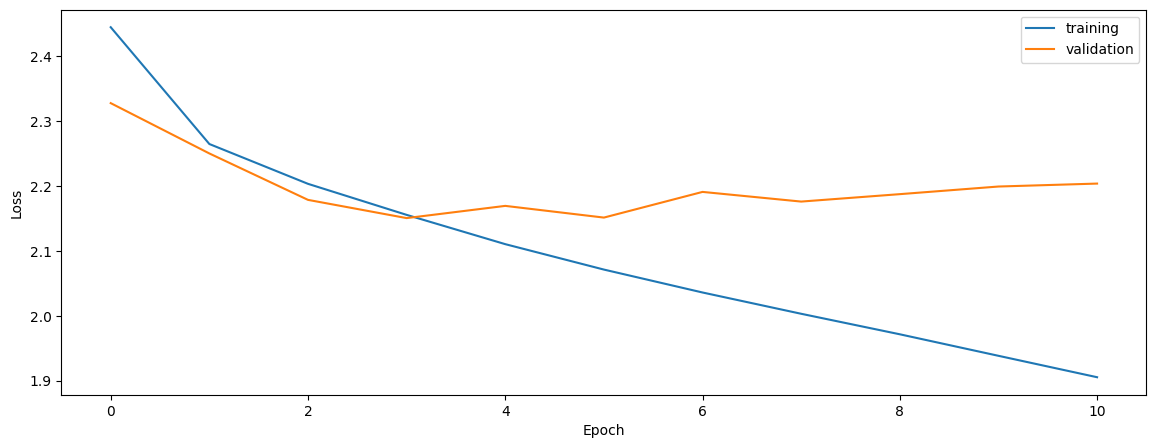

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train


0.2686969047226346
0.27188225027402857
0.21206458933963135


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.34981215301543844
0.39233272375215145
0.3259565463984992


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.35341464044856724
0.3911321377489273
0.3299223043395869


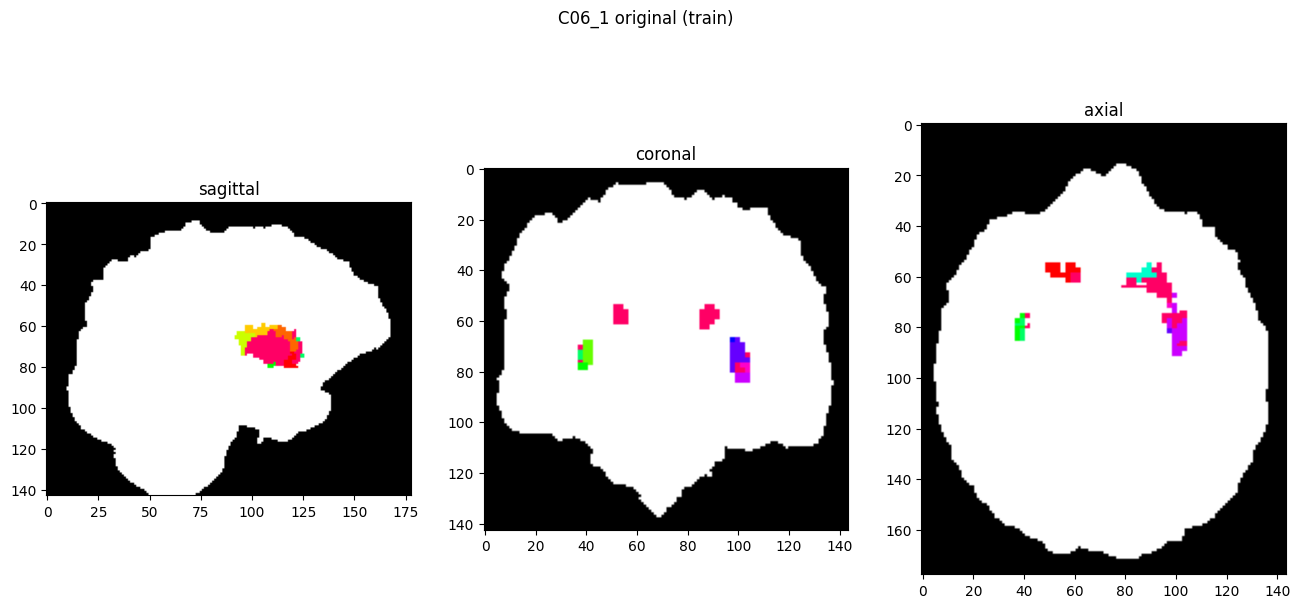

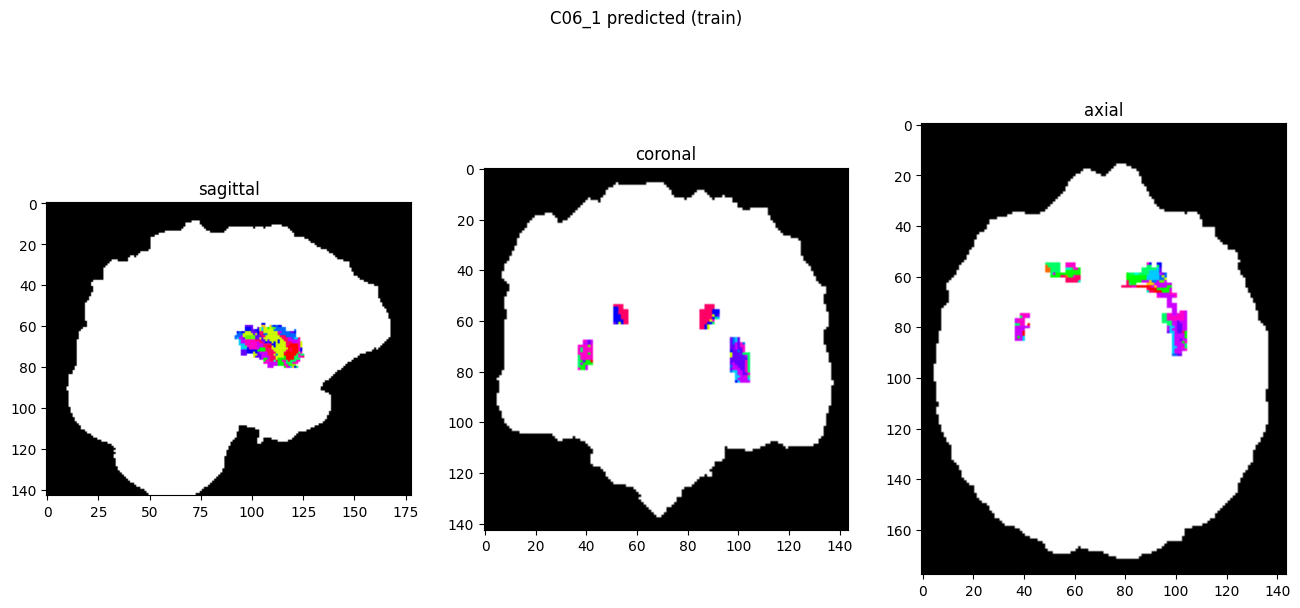

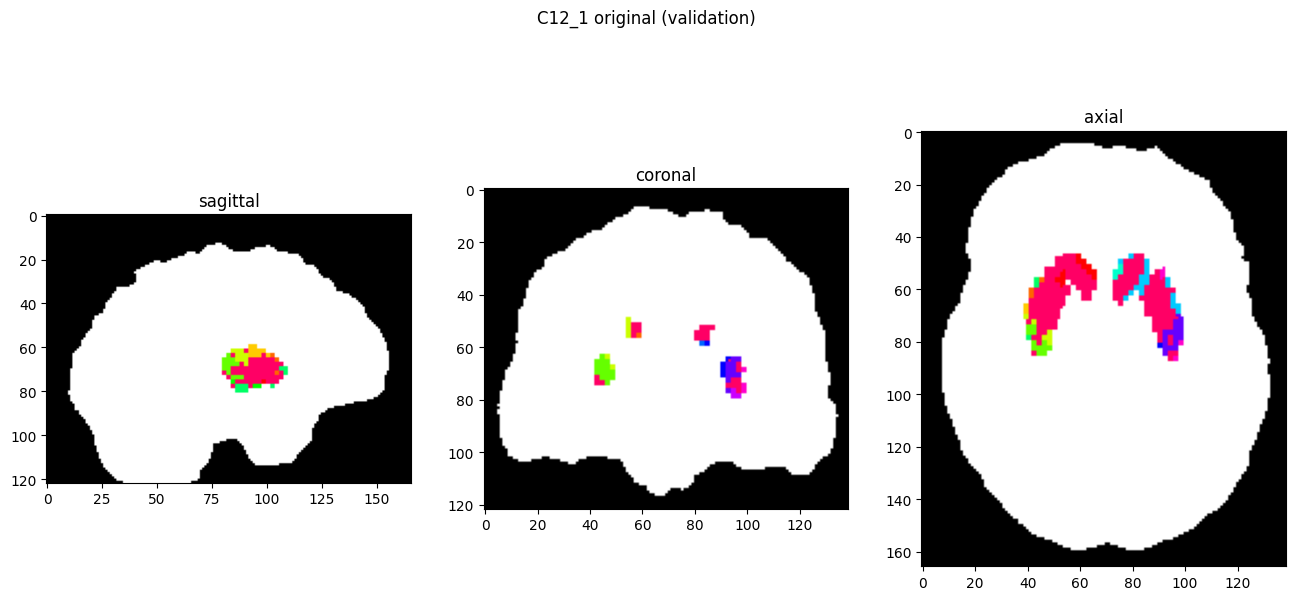

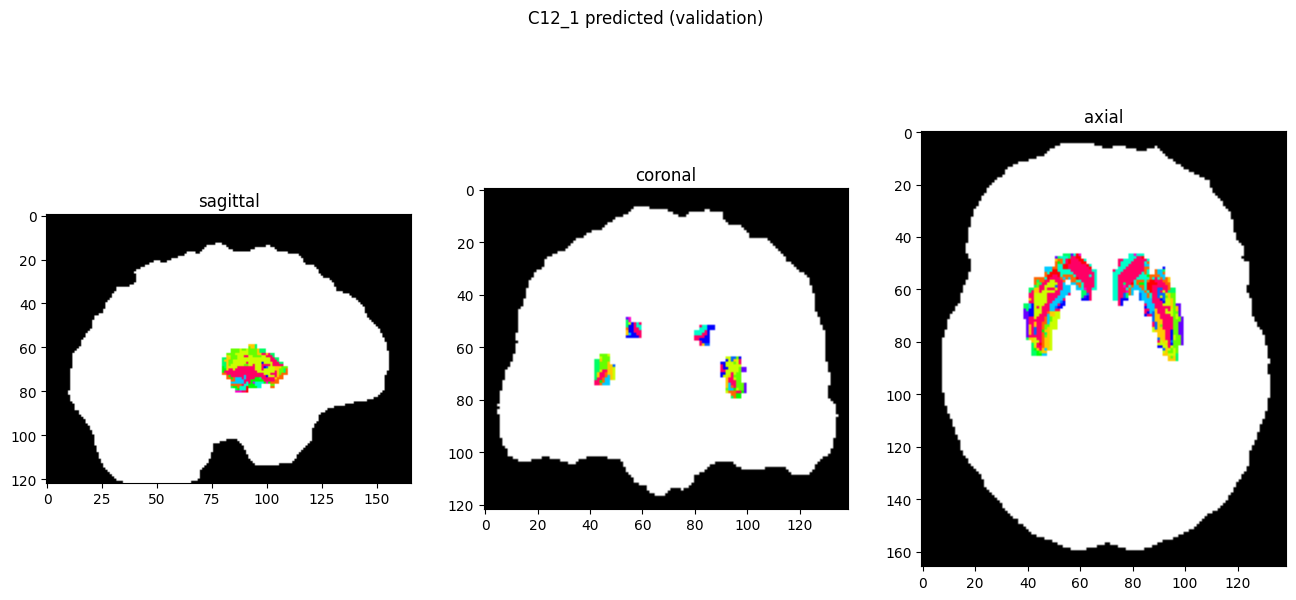

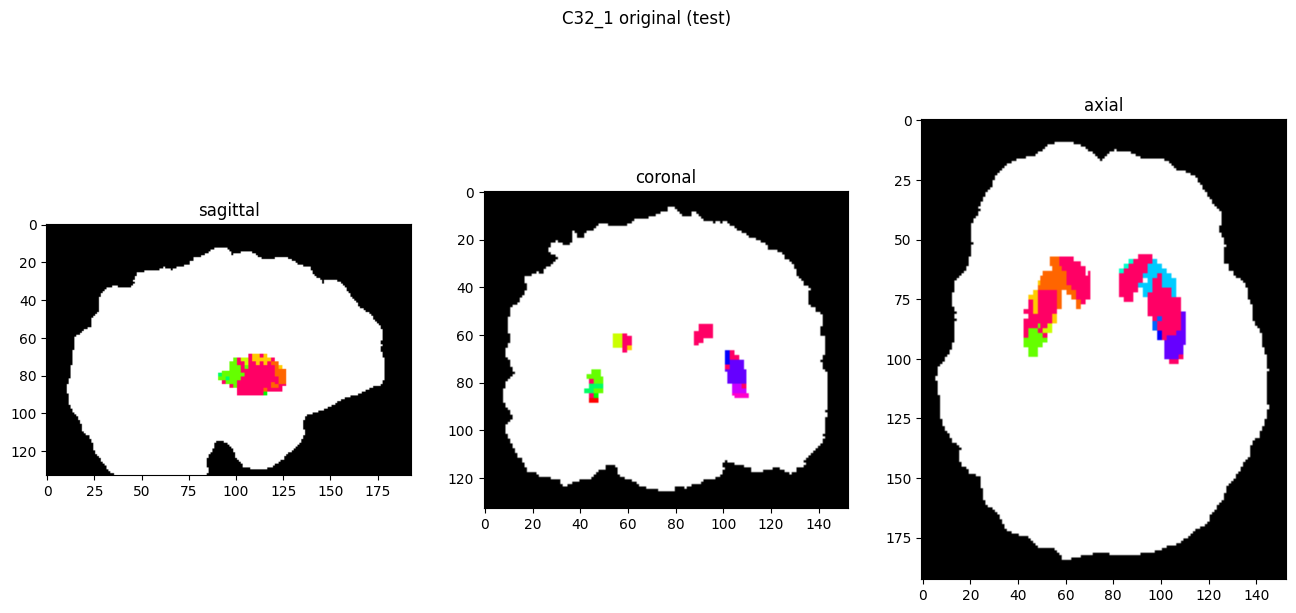

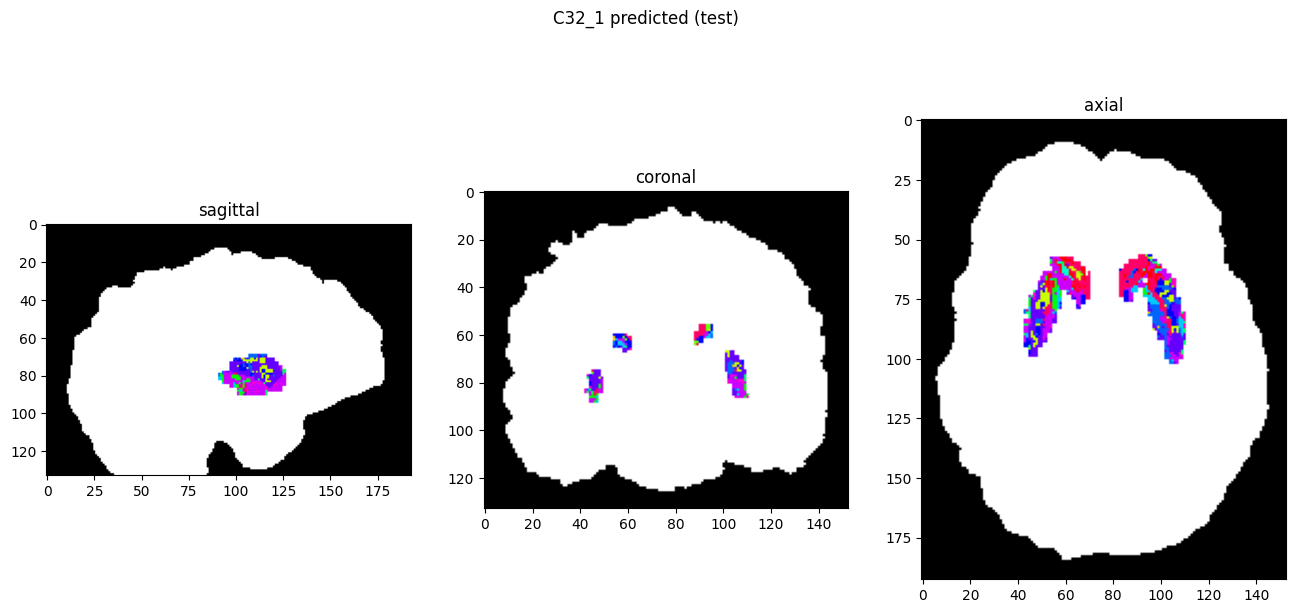

In [10]:
showResults(model, gen, threshold=0)